In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
import fitsio
import glob
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, get_random, flux_to_mag, bgsmask, getBGSbits, match_coord
from cuts import getGeoCuts, get_stars, get_galaxies, bgsbut
from QA import hexbin

from postages_images import postages_circle

#from main_def import get_random, flux_to_mag, get_sweep_whole, bgsmask, getGeoCuts
#from photometric_def import get_stars, get_galaxies
#from main_def import get_random, hexbin

#import seaborn as sns
#sns.set()

import warnings
warnings.filterwarnings('ignore')


## Input files

In [2]:
#
dr = 'dr8'
survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'south' #'svfields_ij'
dec_resol_ns = 32.375
if (dr[:3] == 'dr9'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_%s_match_gama' %(dr, survey, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)
    
if reg[:8] == 'svfields': desifootprint = False
else: desifootprint = True

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [3]:
gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

gamafield = np.empty_like(gama['RA'], dtype='S4')
for i, field in enumerate(gama['SPECID']):
    #print(i, field[:3])
    if field[:1] == 'G': gamafield[i] = field[:3]
    else: gamafield[i] = 'OTHR'

fraction of gama good quality: 186137 / 221373


In [4]:

def get_isgama(ra, dec):
    
    keep = np.zeros_like(ra, dtype='?')

   # keep |= ((ra > 174.) & (ra < 186.) & (dec > -3.) & (dec < 2.)) #G12
    keep |= ((ra > 211.5) & (ra < 223.5) & (dec > -2.) & (dec < 3.)) #G15
    #keep |= ((ra > 129.) & (ra < 141.) & (dec > -2.) & (dec < 3.)) #G09
    
    return keep

def gama12():
    
    return [174., 186., -3., 2.]

def gama15():
    
    return [211.5, 223.5, -2., 3.]

def gama09():
    
    return [129., 141., -2., 3.]


# load whole LS (i.e., not limited by rmag < 20) within GAMA footprint

We use the \GAMA DR3 Main Survey, which has a $98.85 \%$ redshift completeness, to match with our \BGS target catalogue. In terms of the footprint and quality of the \GAMA data, we choose three out of the four \GAMA fields: G09, G12, G15, ignoring G02 as this is only partialy covered by \DECaLS footprint. \GAMA main survey is complete to r petrosian (\RPETRO) of $19.8$ and to get reliable redshifts, we select targets with \GAMA \NQ with a value of $3$ or more. The area of each \GAMA field is $59.98$ deg$^2$ meaning that our matched sample has a total area of $\sim 180$ deg$^2$.

In principle, we match \GAMA with the whole LS \DReight within the \GAMA footprint rather than match \GAMA with \BGS allowing us to know more about our \BGS catalogue. 


In [6]:
### load catalogue
# this is dr8/dr9d sweeps in decals with BGSBITS 
#cat =  get_sweep_whole(patch=gama15(), dr=dr+'-'+survey, rlimit=None, maskbitsource=False, bgsbits=True, opt='1')

if True:
    #get sweeps for GAMA footprint
    lsin12 =  get_sweep_whole(patch=gama12(), dr=dr+'-'+survey, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')
    lsin15 =  get_sweep_whole(patch=gama15(), dr=dr+'-'+survey, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')
    lsin09 =  get_sweep_whole(patch=gama09(), dr=dr+'-'+survey, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')
    # merge the LS in GAMA fileds targets in a single data frame
    cat = np.concatenate((lsin12, lsin15, lsin09))

sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_174.0_186.0_-3.0_2.0.npy
Total run time: 0.000861 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_211.5_223.5_-2.0_3.0.npy
Total run time: 0.001134 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_129.0_141.0_-2.0_3.0.npy
Total run time: 0.001256 sec


In [7]:
#get rid of stars in GAMA
gama = gama[get_isgama(gama['RA'], gama['DEC'])]
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

gama0 = gama #Include stars and galaxies in GAMA
gama = gama0[gama0['Z'] > 0.002] #Include only galaxies in GAMA


Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.11 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.89 %


## Match BGS catalogue with GAMA DR3

In [8]:
# dr8 in gama
dr8ingama = cat[get_isgama(cat['RA'], cat['DEC'])]

bgs = ((dr8ingama['BGSBITS'] & 2**(20)) != 0)
print('fraction of bgs in %s within GAMA: %i / %i' %(dr, np.sum(bgs), len(dr8ingama)))

fraction of bgs in dr8 within GAMA: 85344 / 4944337


## within MS and outside BS mask?

In [9]:
#
if False:
#
    from QA import circular_mask_radii_func
    from io_ import query_catalog_mask, get_msmask, get_bsmask

    #star catalogue
    masksources = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/dr8_sweep_whole_maskbitsources.npy')
    stars = np.load('/global/cscratch1/sd/qmxp55/pauline/stars_GAIA_TYCHO_13.npy')

    stars = stars[get_isgama(stars['RA'], stars['DEC'])]
    masksources = masksources[get_isgama(masksources['RA'], masksources['DEC'])]
    starsMS = get_msmask(masksources)
    #
    mag = np.linspace(0, 20, 50)
    BS_radii = []
    new_BS_radii = []
    for i,j in enumerate(mag):
        BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
        new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
    #
    def get_MSin_BSout(cat, BSstars, MSstars):
    
        BS_flag = query_catalog_mask(cat['RA'], cat['DEC'], BSstars, BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
    
        MS_flag = query_catalog_mask(cat['RA'], cat['DEC'], MSstars, BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
    
        flag = (MS_flag[0]) & (~BS_flag[0])
        print('N: \t %i' %(np.sum(flag)))
    
        return flag

    #
    cat_flag = get_MSin_BSout(dr8ingama, stars, starsMS)
    gama_flag = get_MSin_BSout(gama, stars, starsMS)
    #
    gama = gama[gama_flag]
    dr8ingama = dr8ingama[cat_flag]
    bgs = bgs[cat_flag]

    print('N: \t %i(gama) \t %i(cat) \t %i(bgs)' %(len(gama), len(dr8ingama), np.sum(bgs)))
    

## Compute BGS completeness and contamination with GAMA

* BGS Contamination: (BGS) & (~GAMA_gal_in_LS)/(GAMA_gal_in_LS)
* BGS Completeness: (BGS) & (GAMA_gal_in_LS)/(GAMA_gal_in_LS)
* GAMA incompleteness: (GAMA_gal_NOT_in_LS)/(GAMA_gal) #this as a function of GAMA r-Petro
* BGS incompleteness: (~BGS) & (GAMA_gal_in_LS)/(GAMA_gal_in_LS)

Where:

* `~GAMA_gal_in_LS`: LS not in GAMA galaxies
* `GAMA_gal_in_LS`: LS in GAMA galaxies
* `GAMA_gal_NOT_in_LS`: GAMA not in LS
* `GAMA_gal`: All GAMA galaxies
    

In [9]:
def match(cat=None, gama=None):
    
    # matching LS with gama stars and galaxies
    idx20, idx10, d2d0, d_ra0, d_dec0 = match_coord(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)

    # LS DR8 matched with gama
    cat_gama = np.zeros_like(cat['RA'], dtype='?') #LS that match with gama
    gama_cat = np.zeros_like(gama['RA'], dtype='?') #gama that match with LS
    cat_z = np.full_like(cat['RA'], -1) #z from gama

    cat_gama[idx20.tolist()] = True
    gama_cat[idx10.tolist()] = True
    cat_z[idx20.tolist()] = gama['Z'][idx10]
    
    return cat_gama, gama_cat, cat_z

In [10]:
ls_gama, gama_ls, ls_z = match(cat=dr8ingama, gama=gama)
gamagal = (ls_z > 0.002)

Doubly matched objects = 0
Final matched objects = 61306


In [11]:
#
def fractions(cat=None, rmaglab=None, match=None, gamagal=None, mask=None, cumu=True):
    
    if mask is None: mask = np.ones_like(cat['RA'], dtype=bool)
    if gamagal is None: gamagal = np.ones_like(cat['RA'], dtype=bool)
        
    rmagl = []
    Ncomp = []
    Ncont = []
    Nincomp = []
    Ngama_ls = []
    Ntot = []

    #for i in np.linspace(15, 20, 30):
    rmags = np.linspace(12, 20.2, 40)
    bins = (rmags[1] - rmags[0])/2
    for num, i in enumerate(rmags[:-1]):
    
        if cumu:
            rlim = (cat[rmaglab] < i)
            keep = (rlim) & (mask)
            keepall = (match) & (rlim) 
            Ntot_ = np.sum((rlim) & (mask))
            rmagl.append(i)
            #NgamaGal.append(np.sum((cat['RMAG'] < i) & ))
        else:
            rlim = (cat[rmaglab] < rmags[num+1]) & (cat[rmaglab] > rmags[num])
            keep = (rlim) & (mask)
            Ntot_ = np.sum((rlim) & (mask))
            keepall = (match) & (rlim)
            rmagl.append(i+bins)
    
        Ncomp.append(np.sum((keep) & (match) & (gamagal))) #completeness
        Ncont.append(np.sum((keep) & (~match))) #contamination
        Nincomp.append(np.sum((rlim) & (~mask) & (match) & (gamagal))) #incompleteness
        
        if np.sum((keepall) & (gamagal)) == 0:
            Ngama_ls.append(np.nan)
        else:
            Ngama_ls.append(np.sum((keepall) & (gamagal))) #gama galaxies
        Ntot.append(Ntot_) #total; BGS if mask=bgs
        
    return np.array(rmagl), np.array(Ncomp), np.array(Ncont), np.array(Nincomp), np.array(Ngama_ls), np.array(Ntot)


In [12]:
#
'''
fcomp = Ncomp/Ngama_ls
fcont = Ncont/Ngama_ls
fincom = Nincomp/Ngama_ls
fGincom = Ncont/Ntot
'''

bgsbutlg = bgsbut(bgsbits=dr8ingama['BGSBITS'], rmag=dr8ingama['RMAG'], pop=['LG'], bgsmask=bgsmask(), rlimit=20)

rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = fractions(cat=dr8ingama, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=bgsbutlg, cumu=False)
rpetrol, _, Ngcont, _, _, Ngtot = fractions(cat=gama, rmaglab='R_PETRO', match=gama_ls, gamagal=None, mask=None, cumu=False)

#
rmagl_c, Ncomp_c, Ncont_c, Nincomp_c, Ngama_ls_c, Ntot_c = fractions(cat=dr8ingama, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=bgsbutlg, cumu=True)
rpetrol_c, _, Ngcont_c, _, _, Ngtot_c = fractions(cat=gama, rmaglab='R_PETRO', match=gama_ls, gamagal=None, mask=None, cumu=True)

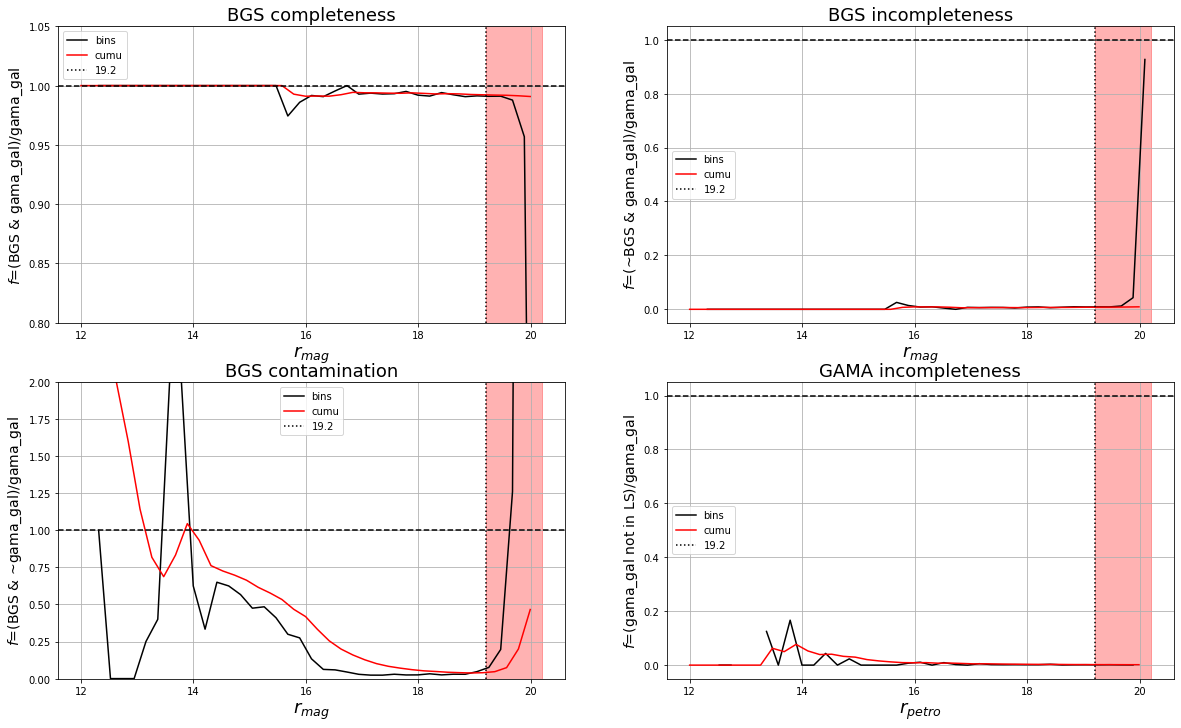

In [13]:
#
fig = plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.title(r'BGS completeness', size=18)
plt.plot(rmagl, Ncomp/Ngama_ls, c='k', ls='-', label='bins')
plt.plot(rmagl_c, Ncomp_c/Ngama_ls_c, c='r', ls='-', label='cumu')
plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
plt.axhline(1, ls='--', c='k')
plt.axvline(19.2, ls=':', label='19.2', color='k')
plt.xlabel(r'$r_{mag}$', size=18)
plt.ylabel(r'$f$=(BGS & gama_gal)/gama_gal', size=14)
plt.ylim(0.8, 1.05)
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.title(r'BGS incompleteness', size=18)
plt.plot(rmagl, Nincomp/Ngama_ls, c='k', ls='-', label='bins')
plt.plot(rmagl_c, Nincomp_c/Ngama_ls_c, c='r', ls='-', label='cumu')
plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
plt.axhline(1, ls='--', c='k')
plt.axvline(19.2, ls=':', label='19.2', color='k')
plt.xlabel(r'$r_{mag}$', size=18)
plt.ylabel(r'$f$=(~BGS & gama_gal)/gama_gal', size=14)
#plt.ylim(0, 0.2)
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.title(r'BGS contamination', size=18)
plt.plot(rmagl, Ncont/Ngama_ls, c='k', ls='-', label='bins')
plt.plot(rmagl_c, Ncont_c/Ngama_ls_c, c='r', ls='-', label='cumu')
plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
plt.axhline(1, ls='--', c='k')
plt.axvline(19.2, ls=':', label='19.2', color='k')
plt.xlabel(r'$r_{mag}$', size=18)
plt.ylabel(r'$f$=(BGS & ~gama_gal)/gama_gal', size=14)
plt.ylim(0, 2)
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.title(r'GAMA incompleteness', size=18)
plt.plot(rpetrol, Ngcont/Ngtot, c='k', ls='-', label='bins')
plt.plot(rpetrol_c, Ngcont_c/Ngtot_c, c='r', ls='-', label='cumu')
plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
plt.axhline(1, ls='--', c='k')
plt.axvline(19.2, ls=':', label='19.2', color='k')
plt.xlabel(r'$r_{petro}$', size=18)
plt.ylabel(r'$f$=(gama_gal not in LS)/gama_gal', size=14)
plt.legend()
plt.grid()

file = pathdir+'fraction_stars_gal'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

## Match GAMA galaxies withLS DR8

In [10]:
# matching LS8 with gama galaxies
idx2, idx1, d2d, d_ra, d_dec = match_coord(dr8ingama['RA'], dr8ingama['DEC'], gama['RA'], gama['DEC'], search_radius=1)

Doubly matched objects = 0
Final matched objects = 61160


mean: 0.094, 	 std: 0.092
3-sigma: 0.371 	 -0.183


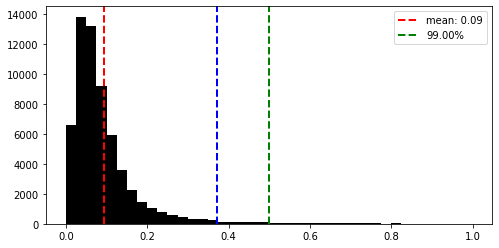

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(d2d, 40, color='k')

std1 = np.std(d2d)
mean = np.mean(d2d)

perc = 99.0
plt.axvline(mean, ls='--', c='r', lw=2, label='mean: %.2f' %(mean))
plt.axvline(mean+3*std1, ls='--', c='b', lw=2)
plt.axvline(np.percentile(d2d, perc), ls='--', c='g', lw=2, label='%.2f%%' %(perc))

print('mean: %.3f, \t std: %.3f' %(mean, std1))
print('3-sigma: %.3f \t %.3f' %(mean+3*std1, mean-3*std1))
plt.legend()


In [12]:
# bgs matched with gama
dr8_gama = np.zeros_like(dr8ingama['RA'], dtype='?') #dr8 that match with gama
dr8_z = np.full_like(dr8ingama['RA'], -1) #z from gama
dr8_rmodel = dr8_z.copy() #r model mag from gama
dr8_sclass = dr8_z.copy() #survey class from gama
dr8_nq = dr8_z.copy() #quality of redshift from gama

dr8_gama[idx2.tolist()] = True
dr8_z[idx2.tolist()] = gama['Z'][idx1]
dr8_rmodel[idx2.tolist()] = gama['R_PETRO'][idx1]
dr8_sclass[idx2.tolist()] = gama['SURVEY_CLASS'][idx1]
dr8_nq[idx2.tolist()] = gama['NQ'][idx1]

# gama matched with bgs
gama_dr8 = np.zeros_like(gama['Z'], dtype='?')
gama_bgs = gama_dr8.copy()
gama_dr8[idx1.tolist()] = True
gama_bgs[idx1.tolist()] = bgs[idx2]


In [13]:
# making a common catalogue
from astropy.table import Table, vstack
Tdr8 = Table()
Tgama = Table()

Tdr8[dr] = np.ones_like(dr8ingama['RA'], dtype='?')
Tdr8['gama'] = dr8_gama
Tdr8['bgs'] = bgs
#Tdr8['lg'] = lg_dr8ingama
Tdr8['Z'] = dr8_z
Tdr8['rpetro'] = dr8_rmodel
#Tdr8['lgbit'] = ~lgbit*1
for i in ['RA', 'DEC', 'TYPE', 'RMAG']:
    Tdr8[i] = dr8ingama[i]

notingama = np.zeros(np.sum(~gama_dr8), dtype='?')
Tgama[dr] = notingama
Tgama['gama'] = ~notingama
Tgama['bgs'] = notingama
#Tgama['lg'] = lg_gama[~gama_dr8]
Tgama['Z'] = gama['Z'][~gama_dr8]
Tgama['rpetro'] = gama['R_PETRO'][~gama_dr8]
#Tgama['lgbit'] = np.full(len(notingama), -1)
for i in ['RA', 'DEC']:
    Tgama[i] = gama[i][~gama_dr8]
Tgama['TYPE'] = np.full(len(notingama), 'None')
Tgama['RMAG'] = np.full(len(notingama), -1)

tab = vstack([Tdr8, Tgama])

In [14]:
from matplotlib_venn import venn3, venn3_circles
def plot_venn3(A, B, C, norm=None, labels=None, file=None):
    '''inputs A, B, C must booleans.'''
    
    A1 = A
    B1 = B
    C1 = C
    AB = (A1) & (B1)
    AC = (A1) & (C1)
    BC = (B1) & (C1)
    ABC = (A1) & (B1) & (C1)
            
    if norm is None: norm, sf = 1, 1
    else: sf = 1
        
    a1 = round((np.sum(A1) - np.sum(AB) - np.sum(AC) + np.sum(ABC))/norm, sf)
    a2 = round((np.sum(B1) - np.sum(AB) - np.sum(BC) + np.sum(ABC))/norm, sf)
    a3 = round((np.sum(AB) - np.sum(ABC))/norm, sf)
    a4 = round((np.sum(C1) - np.sum(AC) - np.sum(BC) + np.sum(ABC))/norm, sf)
    a5 = round((np.sum(AC) - np.sum(ABC))/norm, sf)
    a6 = round((np.sum(BC) - np.sum(ABC))/norm, sf)
    a7 = round(np.sum(ABC)/norm, sf)
        
    if labels is None: labels = ['Group A', 'Group B', 'Group C']
        
    fig = plt.figure(figsize=(14,14))
    v=venn3([a1, a2, a3, a4, a5, a6, a7], set_labels = (labels[0], labels[1], labels[2]))
    c=venn3_circles([a1, a2, a3, a4, a5, a6, a7], linestyle='dotted', linewidth=1, color="grey")
    #c[1].set_lw(1.0)
    c[1].set_ls('solid')
    c[2].set_ls('dashed')
    #c[1].set_color('skyblue')
    
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

    plt.show()

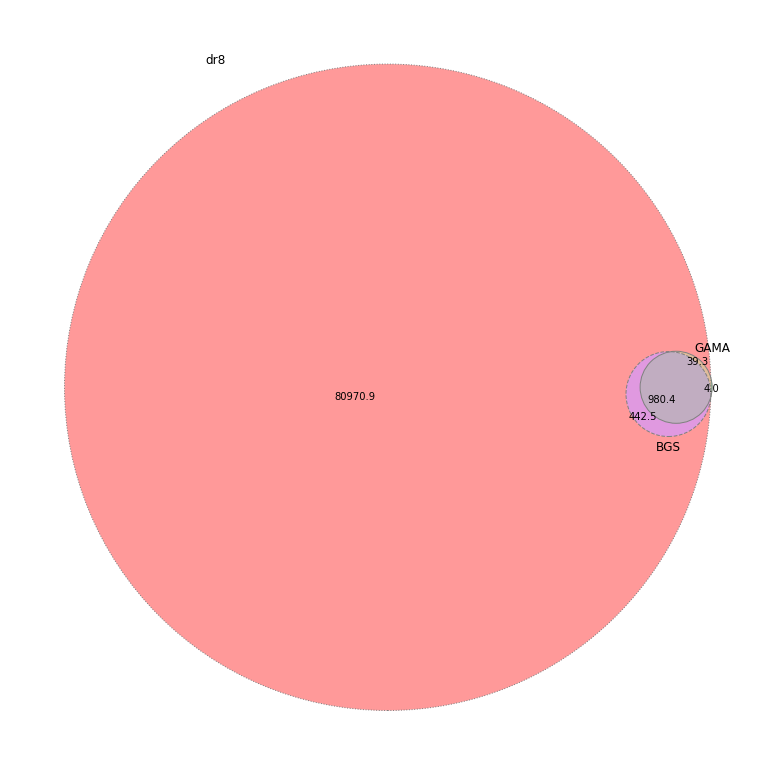

In [15]:
#
Area = 59.98*1
plot_venn3(A=tab[dr], B=tab['gama'], C=tab['bgs'], norm=Area, labels=[dr, 'GAMA', 'BGS'], file=pathdir+'venn_%s_gama_bgs' %(dr))


In [16]:
#
BS = (dr8ingama['MASKBITS'] & 2**1)==0
nobs = (dr8ingama['NOBS_G'] > 0) & (dr8ingama['NOBS_R'] > 0) & (dr8ingama['NOBS_Z'] > 0)

bgsbutsg = bgsbut(bgsbits=dr8ingama['BGSBITS'], rmag=dr8ingama['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=20)
rej_bs_nobs_20_match = ((dr8_z > 0.002)) & (dr8ingama['RMAG'] < 20) & ((~BS) | (~nobs))
sgonly = (~bgs) & (bgsbutsg) & (dr8ingama['RMAG'] < 20) & (dr8_gama)

Ngama_ls = np.sum((tab['gama']) & (tab[dr]))
Ngama_bgs = np.sum((tab['gama']) & (tab['bgs']))
gama_ls_notbgs = (tab['gama']) & (tab[dr]) & (~tab['bgs'])
print('GAMA & LS %s: %.2f /deg^2'%(dr, Ngama_ls/Area))
print('GAMA & BGS: %.2f /deg^2'%(Ngama_bgs/Area))
print('GAMA in LS %s but not in BGS: %.2f /deg^2'%(dr, np.sum(gama_ls_notbgs)/Area))
print('\t because rmag > 20: %.2f /deg^2' %(np.sum((gama_ls_notbgs) & (tab['RMAG'] > 20))/Area))
print('\t because was rejected by any of BGS cuts: %.2f /deg^2' %(np.sum((gama_ls_notbgs) & (tab['RMAG'] < 20))/Area))

print('\t \t because missed by BS+NOBS: %.2f /deg^2' %(np.sum(rej_bs_nobs_20_match)/Area))
print('\t \t because SG only (i.e., not missed by any other BGS cut): %.2f /deg^2' %(np.sum(sgonly)/Area))

print('percentage of GAMA in LS %s: %.2f %%' %(dr, 100 * Ngama_ls/np.sum(tab['gama'])))
print('percentage of LS %s in GAMA: %.2f %%' %(dr, 100 * Ngama_ls/np.sum(tab[dr])))

GAMA & LS dr8: 1019.67 /deg^2
GAMA & BGS: 980.38 /deg^2
GAMA in LS dr8 but not in BGS: 39.30 /deg^2
	 because rmag > 20: 19.62 /deg^2
	 because was rejected by any of BGS cuts: 19.64 /deg^2
	 	 because missed by BS+NOBS: 8.20 /deg^2
	 	 because SG only (i.e., not missed by any other BGS cut): 5.70 /deg^2
percentage of GAMA in LS dr8: 99.61 %
percentage of LS dr8 in GAMA: 1.24 %


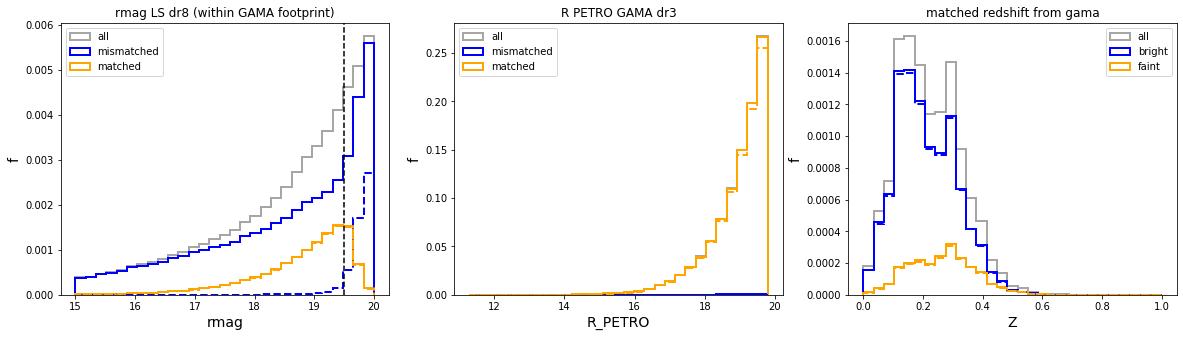

In [17]:
 fig = plt.figure(figsize=(20,5))
N = len(dr8ingama['RA'])
cumu = False
plt.subplot(1,3,1)
bins = np.linspace(15, 20, 30)
plt.title(r'rmag LS %s (within GAMA footprint)' %(dr))
plt.hist(dr8ingama['RMAG'], bins=bins, weights=np.full(N, 1/N), histtype='step',cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(dr8ingama['RMAG'][~dr8_gama], bins=bins, weights=np.full(np.sum(~dr8_gama), 1/N), histtype='step', cumulative=cumu, lw=2, color='blue', label='mismatched')
plt.hist(dr8ingama['RMAG'][dr8_gama], bins=bins, weights=np.full(np.sum(dr8_gama), 1/N), histtype='step',cumulative=cumu, lw=2, color='orange', label='matched')
plt.hist(dr8ingama['RMAG'][(~dr8_gama) & (bgs)], bins=bins, weights=np.full(np.sum((~dr8_gama) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
plt.hist(dr8ingama['RMAG'][(dr8_gama) & (bgs)], bins=bins, weights=np.full(np.sum((dr8_gama) & (bgs)), 1/N), histtype='step',cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'rmag', size=14)
plt.ylabel(r'f', size=14)
plt.legend(loc='upper left')
plt.axvline(19.5, ls='--', c='k')

plt.subplot(1,3,2)
Ng = len(gama['R_PETRO'])
ylim = np.percentile(gama['R_PETRO'][(gama['R_PETRO'] > 0) & (np.isfinite(gama['R_PETRO']))],(0,99.5))
mask0 = (gama['R_PETRO'] > ylim[0]) & (gama['R_PETRO'] < ylim[1])
bins = np.linspace(ylim[0], ylim[1], 30)
plt.title(r'R PETRO GAMA dr3')
plt.hist(gama['R_PETRO'][mask0], bins=bins, weights=np.full(np.sum(mask0), 1/Ng), histtype='step',cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(gama['R_PETRO'][(mask0) & (~gama_dr8)], bins=bins, weights=np.full(np.sum((mask0) & (~gama_dr8)), 1/Ng), histtype='step', cumulative=cumu, lw=2, color='blue',label='mismatched')
plt.hist(gama['R_PETRO'][(mask0) & (gama_dr8)], bins=bins, weights=np.full(np.sum((mask0) & (gama_dr8)), 1/Ng), histtype='step',cumulative=cumu, lw=2, color='orange',label='matched')
plt.hist(gama['R_PETRO'][(mask0) & (~gama_dr8) & (gama_bgs)], bins=bins, weights=np.full(np.sum((mask0) & (~gama_dr8) & (gama_bgs)), 1/Ng), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
plt.hist(gama['R_PETRO'][(mask0) & (gama_dr8) & (gama_bgs)], bins=bins, weights=np.full(np.sum((mask0) & (gama_dr8) & (gama_bgs)), 1/Ng), histtype='step',cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'R_PETRO', size=14)
plt.ylabel(r'f', size=14)
plt.legend(loc='upper left')
#plt.axvline(19.5, ls='--', c='k')

plt.subplot(1,3,3)
mask = (dr8_gama) & (dr8_z > 0) & (dr8_z < 1)
maskB = (dr8_gama) & (dr8_z > 0) & (dr8_z < 1) & (dr8ingama['RMAG'] < 19.5)
maskF = (dr8_gama) & (dr8_z > 0) & (dr8_z < 1) & (dr8ingama['RMAG'] > 19.5) & (dr8ingama['RMAG'] < 20.)
bins = np.linspace(0,1,30)

plt.title(r'matched redshift from gama')
plt.hist(dr8_z[mask], bins=bins,  weights=np.full(np.sum(mask), 1/N), histtype='step', cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(dr8_z[maskB], bins=bins,  weights=np.full(np.sum(maskB), 1/N), histtype='step', cumulative=cumu, lw=2, color='blue', label='bright')
plt.hist(dr8_z[maskF], bins=bins,  weights=np.full(np.sum(maskF), 1/N), histtype='step', cumulative=cumu, lw=2, color='orange', label='faint')
plt.hist(dr8_z[(maskB) & (bgs)], bins=bins,  weights=np.full(np.sum((maskB) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
plt.hist(dr8_z[(maskF) & (bgs)], bins=bins,  weights=np.full(np.sum((maskF) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'Z', size=14)
plt.ylabel(r'f', size=14)
plt.legend()

file = pathdir+'rmag_and_rpetro_nz'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)


mean: 	 0.2198 (all) 	 0.2107 (bright) 	 0.2623 (faint)


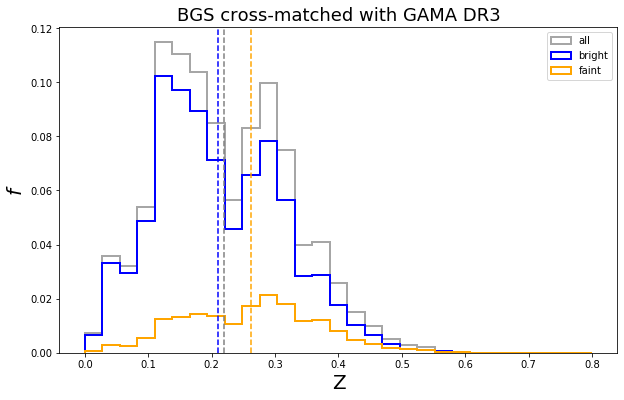

In [18]:
fig = plt.figure(figsize=(10,6))

N = np.sum((dr8_gama) & (bgs))
cumu = False

mask = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (bgs)
maskB = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (dr8ingama['RMAG'] < 19.5) & (bgs)
maskF = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (dr8ingama['RMAG'] > 19.5) & (dr8ingama['RMAG'] < 20.) & (bgs)
bins = np.linspace(0,0.8,30)

plt.title(r'BGS cross-matched with GAMA DR3', size=18)
plt.hist(dr8_z[mask], bins=bins,  weights=np.full(np.sum(mask), 1/N), histtype='step', cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
plt.hist(dr8_z[maskB], bins=bins,  weights=np.full(np.sum(maskB), 1/N), histtype='step', cumulative=cumu, lw=2, color='blue', label='bright')
plt.hist(dr8_z[maskF], bins=bins,  weights=np.full(np.sum(maskF), 1/N), histtype='step', cumulative=cumu, lw=2, color='orange', label='faint')

print('mean: \t %.4f (all) \t %.4f (bright) \t %.4f (faint)' %(
    np.mean(dr8_z[mask]), np.mean(dr8_z[maskB]), np.mean(dr8_z[maskF])
    ))
plt.axvline(np.mean(dr8_z[mask]), ls='--', c='gray')
plt.axvline(np.mean(dr8_z[maskB]), ls='--', c='blue')
plt.axvline(np.mean(dr8_z[maskF]), ls='--', c='orange')

#plt.hist(dr8_z[(maskB) & (bgs)], bins=bins,  weights=np.full(np.sum((maskB) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
#plt.hist(dr8_z[(maskF) & (bgs)], bins=bins,  weights=np.full(np.sum((maskF) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'Z', size=20)
plt.ylabel(r'$f$', size=20)
plt.legend()

file = pathdir+'bgs_nz'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)


In [28]:
#
def hexbin(secmask=None, title=None, C=None, clab=None, file=None, xlim=None, ylim=None, vmax=None, vmaxpsf=None, dr='dr8'):
    
    #fig,ax = plt.subplots(2,2, figsize=(18,12))
    cols, rows = 2, 3
    fig = plt.figure(figsize=(7*cols,6*rows))
    gs = gridspec.GridSpec(rows,cols,hspace=0.30,wspace=0.1)
    
    cmap = plt.get_cmap('coolwarm', 8)
    
    if secmask is None: secmask = np.ones_like(dr8ingama['RA'], dtype=bool)
    
    y = (dr8ingama['RMAG'] - dr8_rmodel)
    x = dr8_rmodel
    if ylim is None: ylim = np.percentile(y[dr8_gama][np.isfinite(y[dr8_gama])],(0.1,99.8))
    if xlim is None: xlim = np.percentile(x[secmask][np.isfinite(x[secmask])],(0,100))
    mask0 = (y > ylim[0]) & (y < ylim[1]) & (x > xlim[0]) & (x < xlim[1]) & (dr8_gama) & (secmask)
    tot = np.sum(mask0)
    
    print('GENERAL: median = %2.3g, mean = %2.3g' %(np.median(y[mask0]), np.mean(y[mask0])))
    if dr[:3] == 'dr8':
        morphs = ['DEV ', 'EXP ', 'REX ', 'COMP', 'PSF ']
    elif dr[:3] == 'dr9':
        morphs = ['DEV', 'EXP', 'REX', 'SER', 'PSF']


    #for i, morph in enumerate(['DEV ', 'EXP ']):
    for i, morph in enumerate(morphs):
        ax = fig.add_subplot(gs[i])
    
        mask = (mask0) & (dr8ingama['TYPE'] == morph)
        print('\t %s: median = %2.3g, mean = %2.3g' %(morph, np.median(y[mask]), np.mean(y[mask])))
        f = np.sum(mask)/tot
        #if f < 0.1: s, alpha, col = 3, 0.6, colors[i]
        #else: s, alpha, col = 0.3, 0.6, colors[i]
        if C is not None: C0 = C[mask]
        else: C0 = None
            
        if morph == 'PSF ': vmax0 = vmaxpsf
        else: vmax0 = vmax
        vmin = 1.0
        
        bins=None
        ax.set_title(r'%s' %(morph), size=20)
        pos = ax.hexbin(x[mask], y[mask], C=C0, gridsize=(50,50), cmap=cmap, bins=bins, 
                           mincnt=1, alpha=0.8, vmin=vmin, vmax=vmax0)
        
        if clab is None: clab = r'$N$'
        #if i == 2: fig.colorbar(pos, ax=ax, orientation="horizontal", pad=0.2, label=clab)
        
        #compute median and percentiles
        binx = np.linspace(xlim[0], xlim[1], 20)
        binw = (binx[1] - binx[0])/2
        binc, median, lower, upper = [],[],[],[]
        
        for num in range(len(binx)-1):
            keep = (mask) & (x > binx[num]) & (x < binx[num+1])
            
            if np.sum(keep) > 0:
                perc = np.percentile(y[keep][np.isfinite(y[keep])],(20,80))
                binc.append(binx[num] + binw)
                median.append(np.median(y[keep]))
                lower.append(perc[0])
                upper.append(perc[1])
            else:
                continue
        
        ax.plot(binc, median, lw=2, c='r')
        ax.fill_between(binc, upper, lower, facecolor='gray', alpha=0.5)
        #ax.plot(binc, lower, lw=2, c='r')
        #ax.plot(binc, upper, lw=2, c='r')
        #ymean, ymedian = np.mean(y[mask]), np.median(y[mask])
        
        #write out fraction
        dx = np.abs(xlim[1] - xlim[0])/15.
        dy = np.abs(ylim[1] - ylim[0])/15.
        ax.text(xlim[0]+dx, ylim[1]-dy, r'f = %.3f' %(f), size=15)
        #ax.plot(x,y1, marker='*', c='k')
        #ax.plot(x,y2, marker='*', c='r')
        ax.axhline(0, ls=':', lw=3, c='r')
        #ax.axhline(ymean, ls='--', lw=2, c='r', label='mean=%2.3g' %(ymean))
        #ax.axhline(ymedian, ls='--', lw=2, c='r', label='median=%.3f' %(ymedian))
        th = np.linspace(15, 20, 3)
        plt.plot(th, 20 - th, lw=2, ls='--', c='k')
        plt.plot(th, 19.5 - th, lw=2, ls='-', c='k')

        ax.set_xlabel(r'$r_{GAMA}$', size=15)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
        #ax.legend(loc='lower left')
        #[handle.set_sizes([18.0]) for handle in lgnd.legendHandles]
    
        if (i%cols==0): ax.set_ylabel(r'$r_{LS} - r_{GAMA}$', size=20)
    
    #ax = fig.add_subplot(gs[len(morphs)])
    #fig.colorbar(pos, ax=ax, orientation="horizontal", pad=0.2, label=clab)
    
    #cbar = fig.colorbar(pos, shrink=0.95)
    cbar_ax = fig.add_axes([0.7, 0.12, 0.04, 0.2])
    fig.colorbar(pos, cax=cbar_ax)

    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
        


In [30]:
pathdir

'/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_match_gama'

GENERAL: median = -0.116, mean = -0.11
	 DEV : median = -0.184, mean = -0.204
	 EXP : median = -0.0794, mean = -0.0689
	 REX : median = -0.0493, mean = -0.0317
	 COMP: median = -0.141, mean = -0.215
	 PSF : median = 0.653, mean = 0.657


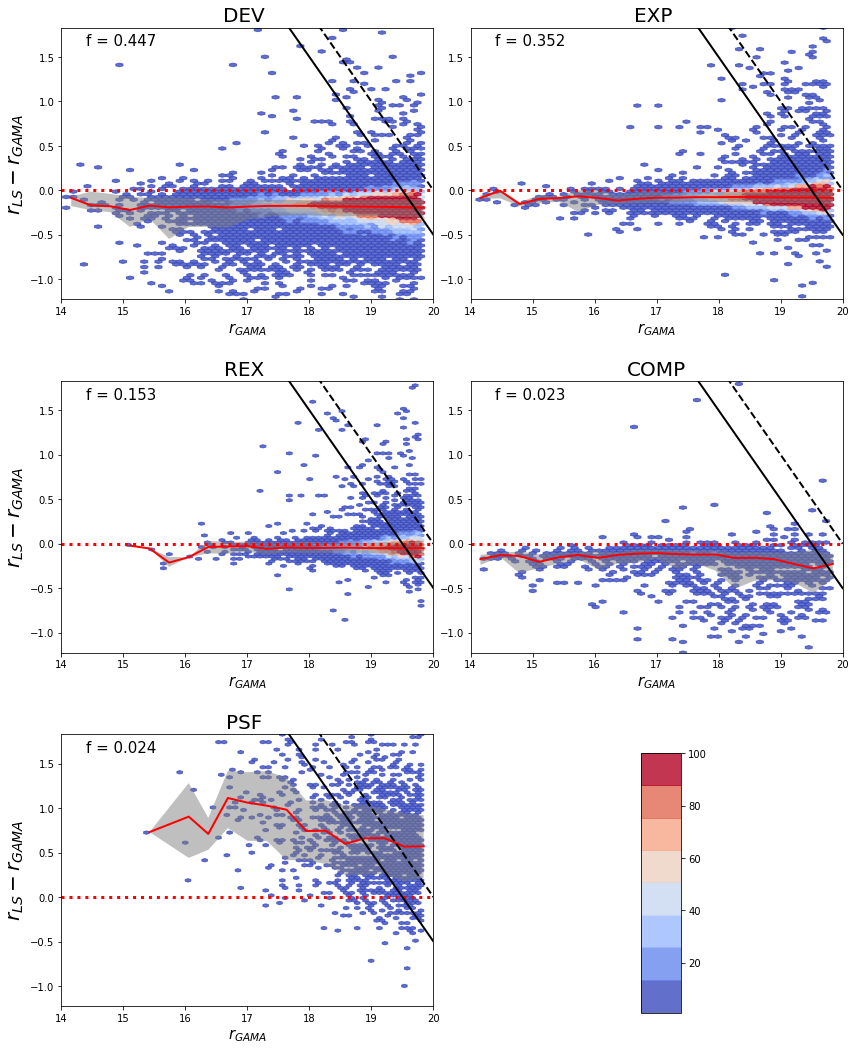

In [29]:
#keep = dr8_z < 0.05
hexbin(secmask=None, title='GAMA Gal & LS DR8', file=pathdir+'bgs_gama_mag_diff', 
       xlim=[14, 20], ylim=None, vmax=100, vmaxpsf=100, dr=dr)

Get the flux ratio between r-band PETROSIAN in GAMA and r-band total magnitude in LS. 

$FLUX_{GAMA}/FLUX_{LS} = 10^{\overline{X}/2.5}$

In [25]:

yy = {'DEV':[-0.188, -0.206], 'EXP':[-0.0852, -0.0747], 'REX':[-0.0544, -0.035], 'COMP':[-0.15, -0.214], 'PSF':[0.66, 0.682]}

for key, val in zip(yy.keys(), yy.values()):
    #print(key, val)
    val1, val2 = val[0], val[1]
    #a = (val/2.5)
    x1 = 10**((val1/2.5))
    x2 = 10**((val2/2.5))
    print('%s: \t %.3f \t %.3f' %(key, x1, x2))

DEV: 	 0.841 	 0.827
EXP: 	 0.925 	 0.934
REX: 	 0.951 	 0.968
COMP: 	 0.871 	 0.821
PSF: 	 1.837 	 1.874


GENERAL: median = -0.132, mean = -0.149
	 DEV: median = -0.197, mean = -0.214
	 EXP: median = -0.0875, mean = -0.0806
	 REX: median = -0.0528, mean = -0.033
	 SER: median = -0.147, mean = -0.176
	 PSF: median = -0.0556, mean = 0.301


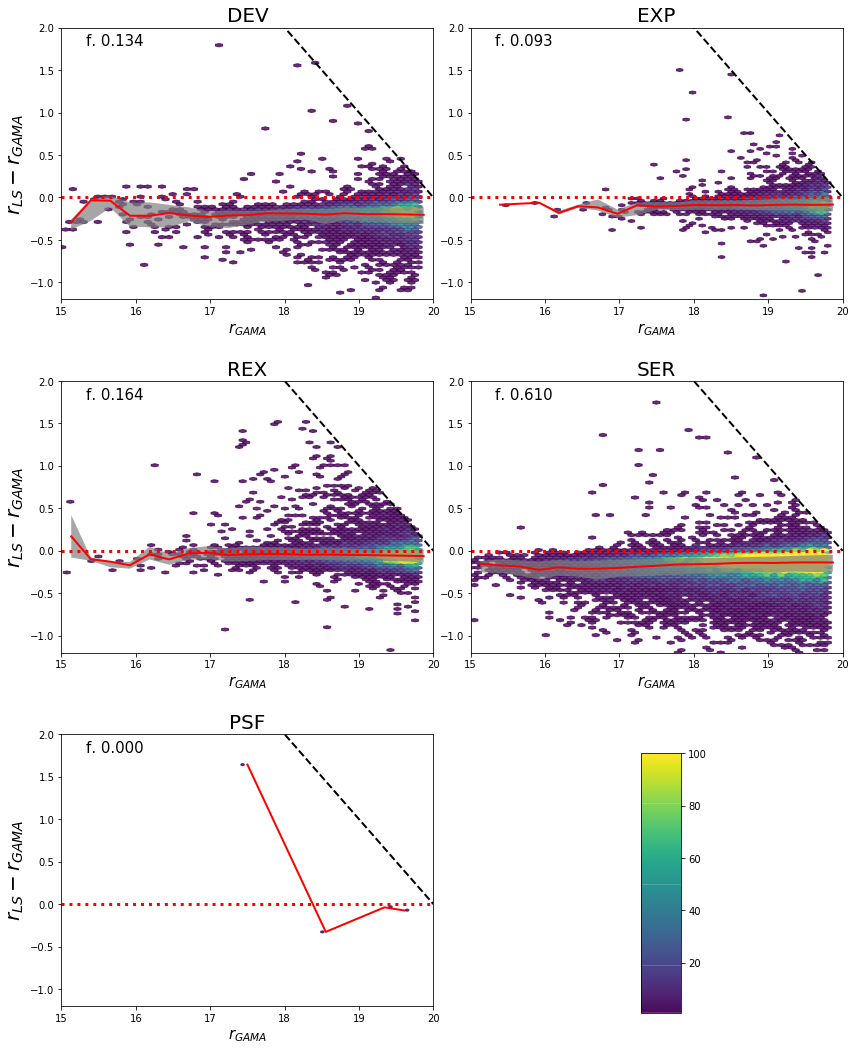

In [26]:
#keep = dr8_z < 0.05
hexbin(secmask=(bgs), title='GAMA & BGS', file=pathdir+'bgs_gama_mag_diff', 
       xlim=[15, 20], ylim=[-1.2, 2], vmax=100, vmaxpsf=500, dr=dr)

GENERAL: median = 0.234, mean = 0.333
	 DEV: median = -0.0706, mean = 0.206
	 EXP: median = 0.448, mean = 0.541
	 REX: median = 0.355, mean = 0.443
	 SER: median = -0.0937, mean = -0.0321
	 PSF: median = 0.468, mean = 0.591


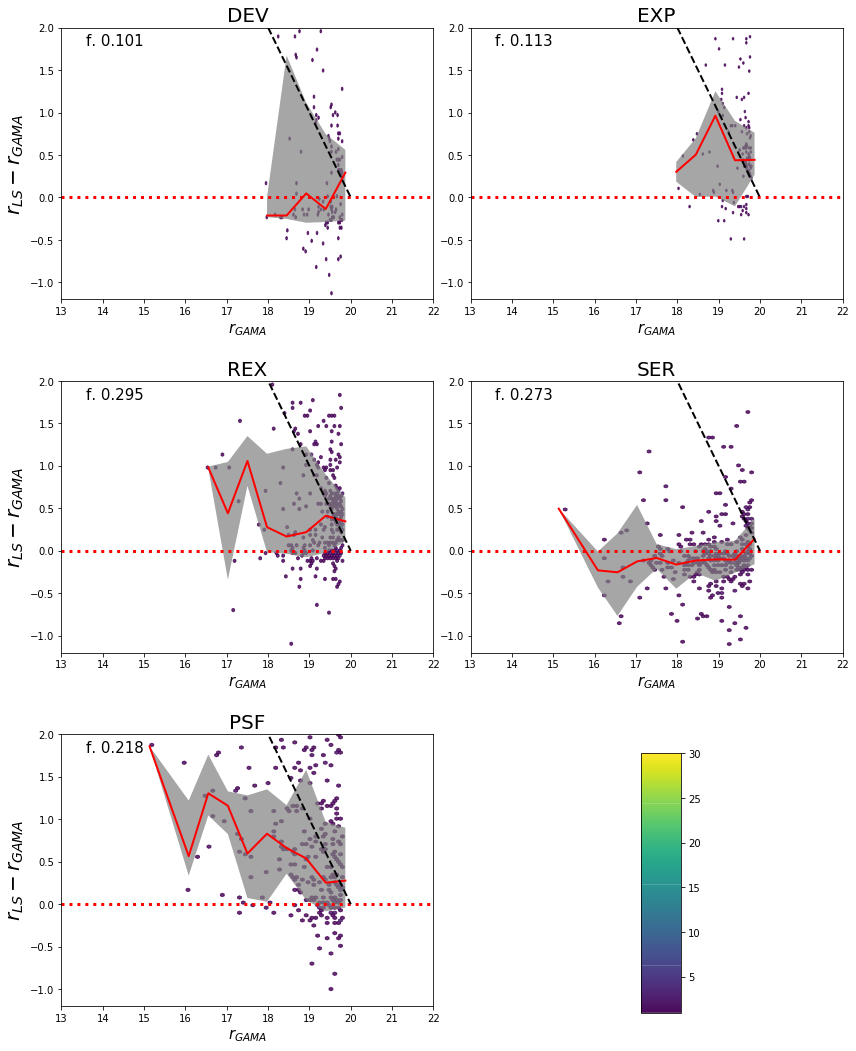

In [27]:
hexbin(secmask=~bgs, title='GAMA & ~BGS', xlim=[13, 22], ylim=[-1.2, 2], vmax=30, vmaxpsf=30, dr=dr)

# PSF-type BGS galaxies assess with GAMA

This section have the aim of investigate the nature of the PSF-type BGS galaxies using GAMA redshifts and comparing ith GAMA r-band pretrosian magnitude. We start with two samples `A) PSF & BGS` and  `B) PSF & BGS & GAMA` and we are going to breal this into three equal-defined samples:

1) & Not in GAIA

2) is a AEN star

3) is a AEN galaxy

We end up with 8 samples: $\{A, A1, A2, A3\}$ $\&$ $\{B, B1, B2, B3\}$.


## defining the samples


========= A:(BGS & PSF): 2.92  deg^2=========
	 A: 100.00 % (2.92 deg^2)
	 A1: 86.29 % (2.52 deg^2)
	 A2: 2.29 % (0.07 deg^2)
	 A3: 11.43 % (0.33 deg^2)
========= B:(BGS & PSF & GAMA): 0.12  deg^2=========
	 B: 100.00 % (0.12 deg^-2)
	 B1: 57.14 % (0.07 deg^-2)
	 B2: 14.29 % (0.02 deg^-2)
	 B3: 28.57 % (0.03 deg^-2)


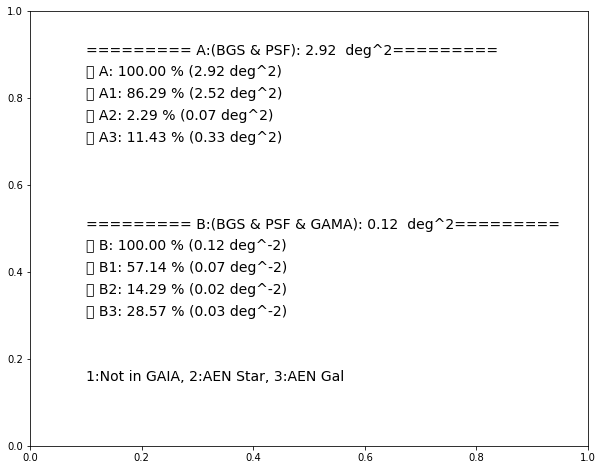

In [26]:
from io_ import gaiaAEN
Ared = Area

inGAIA = dr8ingama['G'] != 0
if dr[:3] == 'dr8': PSF = dr8ingama['TYPE'] == 'PSF '
elif dr[:3] == 'dr9': PSF = dr8ingama['TYPE'] == 'PSF'

    
gaia_star, gaia_gal = gaiaAEN(inGAIA=inGAIA, size=len(dr8ingama['RA']), G=dr8ingama['G'], AEN=dr8ingama['AEN'], dr=dr)

A = (bgs) & (PSF)
A1 = (A) & (~inGAIA)
A2 = (A) & (gaia_star)
A3 = (A) & (gaia_gal)

A0 = {'A':A, 'A1':A1, 'A2':A2, 'A3':A3}

fig = plt.figure(figsize=(10,8))
j = 0
headerA = '========= A:(BGS & PSF): %.2f  deg^2=========' %(np.sum(A)/Ared)
print(headerA)
plt.text(0.1, 0.9, headerA, size=14)
for key, val in zip(A0.keys(), A0.values()):
    text = '\t %s: %.2f %% (%.2f deg^2)' %(key, 100*np.sum(val)/np.sum(A), np.sum(val)/Ared)
    print(text)
    plt.text(0.1, 0.85-j, text, size=14)
    j += 0.05

B = (bgs) & (PSF) & (dr8_gama)
B1 = (B) & (~inGAIA)
B2 = (B) & (gaia_star)
B3 = (B) & (gaia_gal)

B0 = {'B':B, 'B1':B1, 'B2':B2, 'B3':B3}

headerB = '========= B:(BGS & PSF & GAMA): %.2f  deg^2=========' %(np.sum(B)/Ared)
print(headerB)
j = 0
plt.text(0.1, 0.5, headerB, size=14)
for key, val in zip(B0.keys(), B0.values()):
    text = '\t %s: %.2f %% (%.2f deg^-2)' %(key, 100*np.sum(val)/np.sum(B), np.sum(val)/Ared)
    print(text)
    plt.text(0.1, 0.45-j, text, size=14)
    j += 0.05

plt.text(0.1, 0.45-j-0.1, '1:Not in GAIA, 2:AEN Star, 3:AEN Gal', size=14)

file = pathdir+'psf_in_bgs_table'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)


First we reduce or \DECaLS footprint of that of \GAMA resulting in a reduced area of $175$ deg$^2$ after accounting for the geometric maskings (i.e., masking around large galaxies, bright stars, globular clusters and completness in the three bands). The \GAMA fields used are the same G09, G12, G15. Within this footprint, the \BGS PSF-type galaxies have a density of $3.91$ deg$^{-2}$. We subdivide this sample into three disjoint samples: 

1) Not in GAIA (39.33 $\%$)
2) is a AEN star (57.75 $\%$)
3) is a AEN galaxy (2.92 $\%$),

where AEN star and AEN galaxy are stars and galaxies defined by the Astrometric Excess Noise classification addressed in appendix~\ref{app:}. The numbers in parentesis indicate the fraction of targets by each of the samples.




In [27]:
def density_patch(coord=None, xlim=None, ylim=None, nbins=100, plot=False, title=None, nmin=None):
    
    from matplotlib.colors import LogNorm
    from main_def import limits
    
    x, y = coord.keys()
    
    if title is not None: ax.set_title(r'%s' %(title), size=20)
    if xlim is None: xlim = limits()[x]
    if ylim is None: ylim = limits()[y]
    masklims = (coord[x] > xlim[0]) & (coord[x] < xlim[1]) & (coord[y] > ylim[0]) & (coord[y] < ylim[1])
    
    bins = np.linspace(xlim[0], xlim[1], nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    #mesh_x, mesh_y = np.meshgrid(bincenter, bincenter)
    
    xx, yy = coord[x], coord[y]
    
    #taking the 2d histogram and divide by the area of each bin to get the density
    density, _, _ = np.histogram2d(xx, yy, bins=bins)
    if nmin is not None:
        density[density < nmin] = np.nan
    
    if plot:
        plt.figure(figsize=(8, 8))
        plt.imshow(density.transpose(), origin='lower', aspect='equal',
               cmap='seismic', extent=np.array([xlim[0], xlim[1], ylim[0], ylim[1]]), norm=LogNorm()) #, vmin=-3, vmax=3
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xlabel(x, size=20)
        plt.ylabel(y, size=20)
    
    return density


In [28]:
def scatterplot(coord=None, catmask=None, xlim=None, ylim=None, title=None, fig=None, gs=None, n=None, ylab=True, 
                xlab=True, hline=None, vline=None, fmcline=False, file=None, contour1=None):
    
    from main_def import limits
    x, y = coord.keys()
    
    ax = fig.add_subplot(gs[n])
    if title is not None: ax.set_title(r'%s' %(title), size=20)
    if xlim is None: xlim = limits()[x]
    if ylim is None: ylim = limits()[y]
    masklims = (coord[x] > xlim[0]) & (coord[x] < xlim[1]) & (coord[y] > ylim[0]) & (coord[y] < ylim[1])
    
    if catmask is None: 
        keep = masklims
        ax.scatter(coord[x][keep], coord[y][keep])
    else:
        for key, val in zip(catmask.keys(), catmask.values()):
            keep = (val) & (masklims)
            
            if np.sum(keep) < 100: s = 15
            elif np.sum(keep) > 1000: s = 1
            else: s = 3
        
            ax.scatter(coord[x][keep], coord[y][keep], s=s, label=key)
            
    if ylab: ax.set_ylabel(r'%s' %(y), size=20)
    if xlab: ax.set_xlabel(r'%s' %(x), size=20)
    if hline is not None: ax.axhline(hline, ls='--', lw=2, c='r')
    if vline is not None: ax.axvline(vline, ls='--', lw=2, c='r')
    if fmcline: 
        x_N1 = np.linspace(15.5, 17.1, 4)
        ax.plot(x_N1, 2.9 + 1.2 + x_N1, color='r', ls='--', lw=2)
        x_N2 = np.linspace(17.1, 18.3, 4)
        ax.plot(x_N2, x_N2*0.+21.2, color='r', ls='--', lw=2)
        x_N3 = np.linspace(18.3, 20.1, 4)
        ax.plot(x_N3, 2.9 + x_N3, color='r', ls='--', lw=2)
        
    lgnd = plt.legend()
    [handle.set_sizes([20]) for handle in lgnd.legendHandles]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    #contour galaxies
    #np.logspace(0, 2, 5)
    if contour1 is not None:
        bgs_den = density_patch(coord=contour1, xlim=xlim, ylim=ylim, plot=False, nmin=0)
        ax.contour(bgs_den.transpose(), levels=(0, 10), origin='lower', aspect='equal',
              extent=np.array([xlim[0], xlim[1], xlim[0], xlim[1]]), colors='black', alpha=0.3)
        
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
        

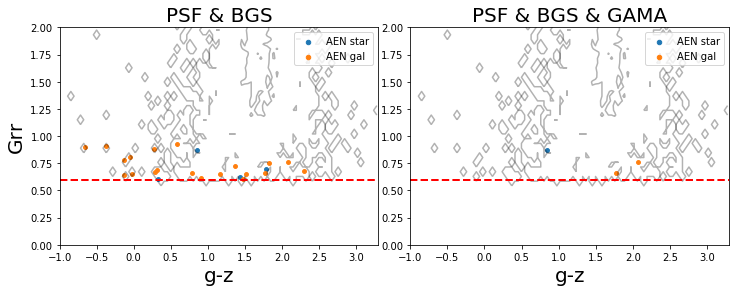

In [29]:
#
Grr = dr8ingama['G'] - 22.5 + 2.5*np.log10(dr8ingama['FLUX_R'])
gz = dr8ingama['GMAG'] - dr8ingama['ZMAG']
coord = {'g-z':gz, 'Grr':Grr}
contourBGS = {'g-z':gz[bgs], 'Grr':Grr[bgs]}
catmasks = [{'AEN star':A2, 'AEN gal':A3}, {'AEN star':B2, 'AEN gal':B3}]
hline, vline = 0.6, None
title = ['PSF & BGS', 'PSF & BGS & GAMA']
    
fig    = plt.figure(figsize=(6*len(catmasks),4))
gs     = gridspec.GridSpec(1,len(catmasks),hspace=0.10,wspace=0.10)
    
for i, catmask in enumerate(catmasks):
        
    if (i%len(catmasks)==0): ylab=True
    else: ylab = False
        
    scatterplot(coord=coord, catmask=catmask, xlim=(-1, 3.3), ylim=(0, 2), title=title[i], fig=fig, gs=gs, n=i, ylab=ylab, 
                hline=hline, vline=vline, fmcline=False, file=None, contour1=contourBGS)
    
file = pathdir+'gz_Grr_PSF'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    

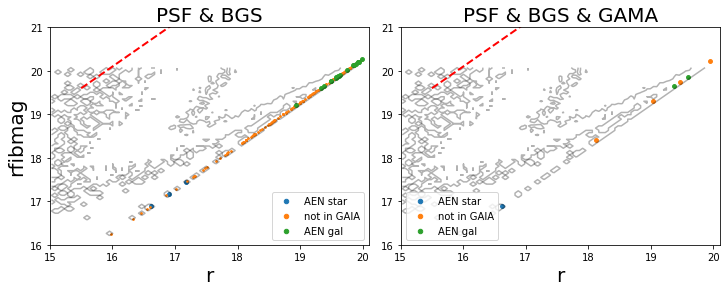

In [30]:
#
coord = {'r':dr8ingama['RMAG'], 'rfibmag':dr8ingama['RFIBERMAG']}
contourBGS = {'r':dr8ingama['RMAG'][bgs], 'rfibmag':dr8ingama['RFIBERMAG'][bgs]}
catmasks = [{'AEN star':A2, 'not in GAIA':A1, 'AEN gal':A3}, {'AEN star':B2, 'not in GAIA':B1, 'AEN gal':B3}]
hline, vline = None, None
title = ['PSF & BGS', 'PSF & BGS & GAMA']
    
fig    = plt.figure(figsize=(6*len(catmasks),4))
gs     = gridspec.GridSpec(1,len(catmasks),hspace=0.10,wspace=0.10)
    
for i, catmask in enumerate(catmasks):
        
    if (i%len(catmasks)==0): ylab=True
    else: ylab = False
        
    scatterplot(coord=coord, catmask=catmask, xlim=None, ylim=(16, 21), title=title[i], fig=fig, gs=gs, n=i, ylab=ylab, 
                hline=hline, vline=vline, fmcline=True, file=None, contour1=contourBGS)
    
file = pathdir+'r_rfibmag_PSF'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    

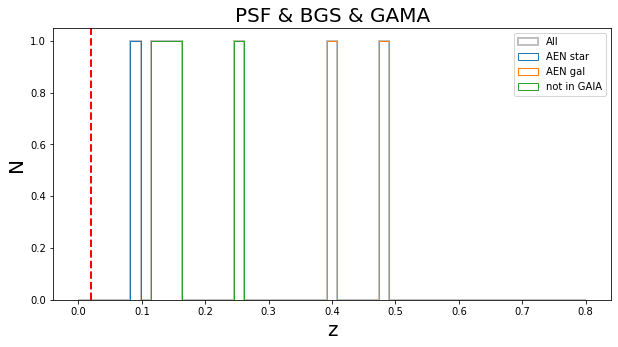

In [31]:
#
fig = plt.figure(figsize=(10, 5))

bins = np.linspace(0, 0.8, 50)
B02 = {'All':B, 'AEN star':B2, 'AEN gal':B3, 'not in GAIA':B1}

for key, val in zip(B02.keys(), B02.values()):
    
    if key == 'All': 
        plt.hist(dr8_z[val], bins=bins, histtype='step', color='gray', alpha=0.5, lw=2, label=key)
    else:
        plt.hist(dr8_z[val], bins=bins, histtype='step', label=key)
        
plt.axvline(0.02, lw=2, c='r', ls='--')
plt.legend()
plt.title('PSF & BGS & GAMA', size=20)
plt.xlabel(r'z', size=20)
plt.ylabel(r'N', size=20)

file = pathdir+'psf_bgs_gama_redshift'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    

# Assess of BGS cuts with GAMA

When cross-matching the reduce \DReight with \GAMA DR3, we get a match target density of $1030.3$ deg$^{-2}$ which represent a fraction of $1.27 \%$ of the reduced \DReight target density and a fraction of $99.6 \%$ of the \GAMA DR3 target density. $948.5$ deg$^{-2}$ out of the $1030.3$ deg$^{-2}$ are \BGS targets and the remain $81.8$ deg$^{-2}$ were rejected by the \BGS cuts where $\sim 4$ deg$^{-2}$ is due to incompleteness in the $r$-band flux. Figure~\ref{fig:} shows heat maps with the target density rejected by each of the spatial and photometric cuts ignoring the rejections by the $r$-band flux incompleteness as these are not related to the \BGS cuts. Note that the reduced \DReight allows fainter than $r$-mag $=20$ objects. Top heatmap include rejectios in the reduced \DReight while bottom heatmap show the subsample of this rejections that has a cross-match with \GAMA.


In [32]:
import seaborn as sns

In [33]:
# see completness in the three bands (G,R,Z)
rfinite = np.isfinite(dr8ingama['RMAG'])
allfinite = (np.isfinite(dr8ingama['RMAG'])) & (np.isfinite(dr8ingama['GMAG'])) & (np.isfinite(dr8ingama['ZMAG']))
print('Target density in LS %s & GAMA & ~BGS of incompleteness in bands' %(dr))
print('in r:',np.sum((~bgs) & (dr8_gama) & (~rfinite))/Area, 'in (g,r,z):', np.sum((~bgs) & (dr8_gama) & (~allfinite))/Area)

Target density in LS dr9k & GAMA & ~BGS of incompleteness in bands
in r: 4.718239413137713 in (g,r,z): 5.068356118706236


#### Potential BGS targets in rejections

In [35]:
#defining the samples

rejs = {}
rejs_gama = {}
rejslist = ['SG', 'LG', 'BS',  'FMC2', 'QC_FI', 'CC', 'QC_FM', 'QC_FF', 'nobs']

print('bgs cut \t all rej \t all rej in GAMA \t PB \t PB&GAMA \t rt \t rt(r<19.5)')
print('---------------------------------------')
for key, val in zip(bgsmask().keys(), bgsmask().values()):
    if key in rejslist: 
        
        mask = ((dr8ingama['BGSBITS'] & 2**(val)) == 0) #& (rfinite) 
        potbgs = bgsbut(bgsbits=dr8ingama['BGSBITS'], rmag=dr8ingama['RMAG'], pop=[key], bgsmask=bgsmask(), rlimit=20)
        potbgs2 = bgsbut(bgsbits=dr8ingama['BGSBITS'], rmag=dr8ingama['RMAG'], pop=[key], bgsmask=bgsmask(), rlimit=19.5)
        rejs[key] = mask
        rejs_gama[key] = (mask) & (dr8_gama)
        
        PB = np.sum((mask) & (potbgs))
        PB2 = np.sum((mask) & (potbgs2))
        PB_gama = np.sum((mask) & (potbgs) & (dr8_gama))
        PB2_gama = np.sum((mask) & (potbgs2) & (dr8_gama))
        gama_all = np.sum(mask & dr8_gama)
        print('%s: \t %i \t %i \t|\t %i \t %.2f \t|\t %.2f \t %.2f' 
              %(key, 
                np.sum(mask), 
                gama_all, 
                PB, 
                PB_gama,
                PB_gama/PB, 
                PB2_gama/PB2
               ))
#excess = (~bgs) & (cat['RMAG'] > 20.)
#print('\t %s: %i' %('excess', np.sum(excess)))

bgs cut 	 all rej 	 all rej in GAMA 	 PB 	 PB&GAMA 	 rt 	 rt(r<19.5)
---------------------------------------
BS: 	 28469 	 87 	|	 222 	 33.00 	|	 0.15 	 0.19
LG: 	 11509 	 550 	|	 548 	 213.00 	|	 0.39 	 0.44
nobs: 	 3434 	 48 	|	 1 	 0.00 	|	 0.00 	 nan
SG: 	 292719 	 523 	|	 175801 	 217.00 	|	 0.00 	 0.00
FMC2: 	 23724 	 286 	|	 120 	 2.00 	|	 0.02 	 0.00
CC: 	 248829 	 309 	|	 80 	 1.00 	|	 0.01 	 0.03
QC_FM: 	 42389 	 154 	|	 301 	 144.00 	|	 0.48 	 0.67
QC_FI: 	 4851 	 356 	|	 57 	 42.00 	|	 0.74 	 0.88
QC_FF: 	 160407 	 165 	|	 465 	 67.00 	|	 0.14 	 0.26


## Gallery of PB within the LG mask

In [36]:
#
mask = ((dr8ingama['BGSBITS'] & 2**(bgsmask()['LG'])) == 0)
potbgs = bgsbut(bgsbits=dr8ingama['BGSBITS'], rmag=dr8ingama['RMAG'], pop=['LG'], bgsmask=bgsmask(), rlimit=20)
PB = (mask) & (potbgs)
PB_gama = (mask) & (potbgs) & (dr8_gama)
PB_not_gama = (mask) & (potbgs) & (~dr8_gama)

print(np.sum(PB), np.sum(PB_gama), np.sum(PB_not_gama))

548 213 335


### PB within LG mask & in GAMA

In [34]:
#
from postages_images import html_postages

coord = [dr8ingama['RA'], dr8ingama['DEC']]
veto = {'bgs & gama':((bgs) & (dr8_gama)),
        'bgs & not gama':((bgs) & (~dr8_gama)),
        'not bgs':((~bgs)),
        #'not bgs & not gama':((~bgs) & (~dr8_gama))
       }

layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]
    
select = PB_gama
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))

html_postages(cat=dr8ingama, coord=coord, idx=idx, notebook=True, savefile=pathdir+'/PB_in_gama_LG', htmltitle='PB_in_gama_LG', 
              veto=veto, grid=[5,6], m=4, radius=4/3600, comparison=None, layer_list=layer_list)


sample size: 79


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_svfields_ij_0.1.0_match_gama/PB_in_gama_LG.html
32.0 122


### PB within LG mask & not in GAMA

In [35]:
#
from postages_images import html_postages

coord = [dr8ingama['RA'], dr8ingama['DEC']]
veto = {'bgs & gama':((bgs) & (dr8_gama)),
        'bgs & not gama':((bgs) & (~dr8_gama)),
        'not bgs':((~bgs)),
        #'not bgs & not gama':((~bgs) & (~dr8_gama))
       }

layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]
    
select = PB_not_gama
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))

html_postages(cat=dr8ingama, coord=coord, idx=idx, notebook=True, savefile=pathdir+'/PB_not_in_gama_LG', htmltitle='PB_not_in_gama_LG', 
              veto=veto, grid=[5,6], m=4, radius=4/3600, comparison=None, layer_list = layer_list)


sample size: 136


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_svfields_ij_0.1.0_match_gama/PB_not_in_gama_LG.html
32.0 122


In [58]:
#
from postages_images import html_postages

coord = [dr8ingama['RA'], dr8ingama['DEC']]
veto = {'bgs & gama':((bgs) & (dr8_gama)),
        'bgs & not gama':((bgs) & (~dr8_gama)),
        'not bgs':((~bgs)),
        #'not bgs & not gama':((~bgs) & (~dr8_gama))
       }

layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]
    
select = (rejs_gama['SG']) & (gaia_star) & (dr8ingama['RMAG'] < 17.7)
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))
name = 'rejs_SG_AEN'

html_postages(cat=dr8ingama, coord=coord, idx=idx, notebook=True, savefile=pathdir+name, htmltitle=name, 
              veto=veto, grid=[2,5], m=4, radius=4/3600, comparison=None, layer_list = layer_list)


sample size: 10


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_svfields_ij_0.1.0_match_gamarejs_SG_AEN.html
32.0 122


In [37]:
def heatmap(data, vmin=None, vmax=None, file=None, ticks=None, fmt=".1f", mask=None):
    
    import pandas as pd
    from matplotlib.colors import LogNorm
    N = len(data.keys())
    keylist = list(data.keys())
    matrix = [[0 for x in range(N)] for y in range(N)]
    if mask is None: mask = np.ones_like(data[keylist[0]], dtype=bool)
    
    from itertools import product
    for i,j in product(range(N), range(N)):
        
        matrix[i][j] = np.sum((data[keylist[i]]) & (data[keylist[j]]) & (mask))/Area
        #print(keylist[i], keylist[j], matrix[i][j]) #sanity check
        
    df = pd.DataFrame(np.tril(np.array(matrix)), columns=keylist, index=keylist)
    df.replace(0, np.nan, inplace=True)
    
    if ticks is None: ticks = np.linspace(vmin, vmax, 5)
    
    fig = plt.figure(figsize=(12,10))
    log_norm = LogNorm(vmin=df.min().min(), vmax=df.max().max())
    ax = sns.heatmap(df, annot=True, annot_kws={"size": 14}, fmt=fmt, linewidths=.5, cmap='Reds',
                   norm=log_norm, vmin = vmin, vmax=vmax, 
                        cbar_kws={"ticks":ticks, 'label': r'objects/deg$^2$'})
    ax.figure.axes[-1].yaxis.label.set_size(22)
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    


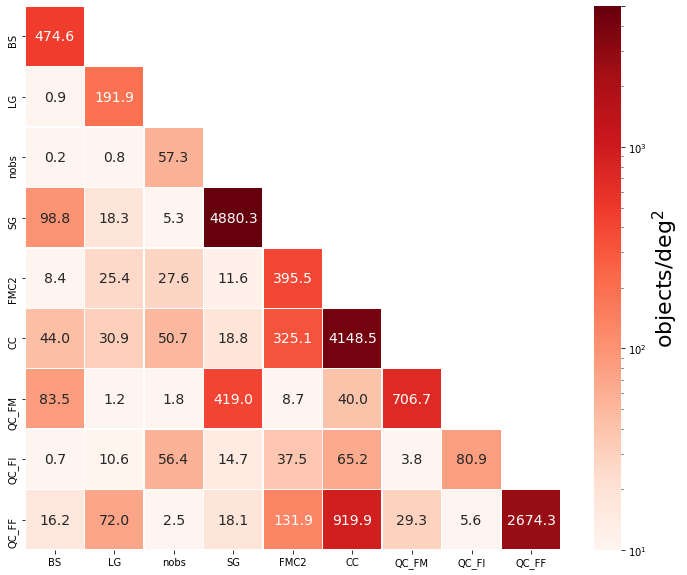

In [38]:
heatmap(rejs, vmin=10, vmax=5000, file=pathdir+'bgs_rejs_heatmap', ticks=[10, 100, 1000, 5000], fmt=".1f")

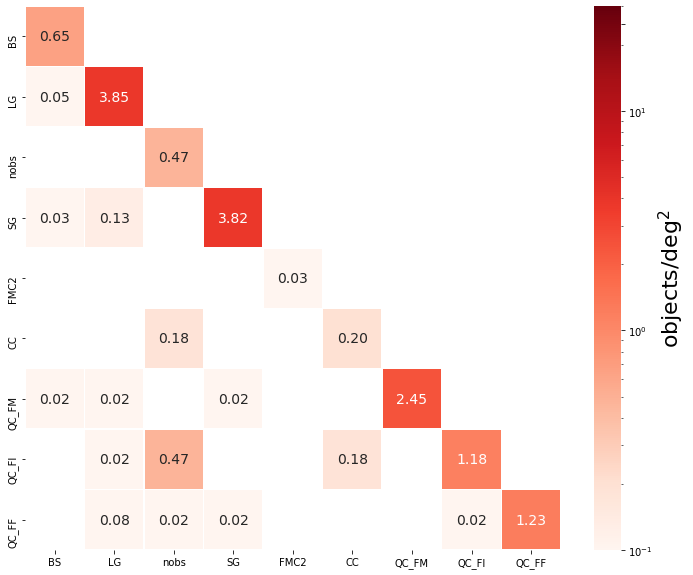

In [39]:
mask = ((dr8_z > 0.002)) & (dr8ingama['RMAG'] < 20)
heatmap(rejs_gama, vmin=0.1, vmax=30, file=pathdir+'bgs_rejs_gama_heatmap', ticks=[0.1, 1, 10, 25], fmt=".2f", mask=mask)

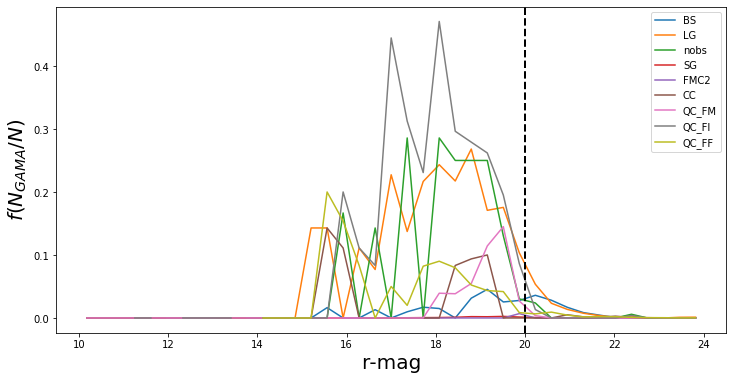

In [41]:
#
N = len(rejs.keys())
keylist = list(rejs.keys())
bins = np.linspace(10, 24, 40)
fig = plt.figure(figsize=(12,6))

for key in keylist:
    
    keep = (np.isfinite(cat['RMAG'])) & (rejs[key])
    keep_gama = (np.isfinite(cat['RMAG'])) & (rejs_gama[key])
    
    w = np.histogram(cat['RMAG'][keep], bins=bins)
    w_gama = np.histogram(cat['RMAG'][keep_gama], bins=bins)
    wcentre = w[1][:-1] + (w[1][1] - w[1][0])/2
    
    plt.plot(wcentre, w_gama[0]/w[0], label=key)

plt.legend()
plt.xlabel(r'r-mag', size=20)
plt.ylabel(r'$f(N_{GAMA}/N)$', size=20)
plt.axvline(20, lw=2, ls='--', c='k')

file = pathdir+'rmag_dist_ratio'
if file is not None:
    fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
        

In [42]:
# adding new param to rejs dicts
#['SG', 'LG', 'BS',  'FMC', 'QC_FI', 'CC', 'QC_IVAR', 'QC_FM', 'QC_FF']

L2 = dr8ingama['REF_CAT'] == 'L6'
other = np.zeros_like(cat, dtype='?')
for i in ['FMC2', 'QC_FI', 'CC', 'QC_FM', 'QC_FF']:
    other |= rejs_gama[i]
    
rejs_gama['other'] = other

print('Are there any LSLGA galaxy outside the BGS catalogue?')
for key in rejslist:
    print('%s & L2: \t (all):%i \t (in GAMA):%i' %(key, np.sum((rejs[key]) & (L2)), np.sum((rejs_gama[key]) & (L2))))
    

Are there any LSLGA galaxy outside the BGS catalogue?
SG & L2: 	 (all):0 	 (in GAMA):0
LG & L2: 	 (all):0 	 (in GAMA):0
BS & L2: 	 (all):0 	 (in GAMA):0
FMC2 & L2: 	 (all):0 	 (in GAMA):0
QC_FI & L2: 	 (all):0 	 (in GAMA):0
CC & L2: 	 (all):0 	 (in GAMA):0
QC_FM & L2: 	 (all):0 	 (in GAMA):0
QC_FF & L2: 	 (all):0 	 (in GAMA):0
nobs & L2: 	 (all):0 	 (in GAMA):0


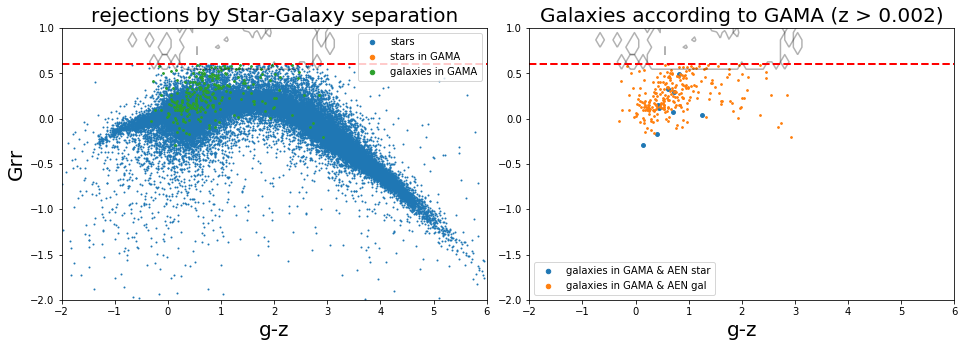

In [43]:
#
Grr = cat['G'] - 22.5 + 2.5*np.log10(cat['FLUX_R'])
gz = cat['GMAG'] - cat['ZMAG']
coord = {'g-z':gz, 'Grr':Grr}
contourBGS = {'g-z':gz[bgs], 'Grr':Grr[bgs]}
catmasks = [{'stars':rejs['SG'], 'stars in GAMA':(rejs_gama['SG']) & (dr8_z < 0.002), 'galaxies in GAMA':(rejs_gama['SG']) & (dr8_z > 0.002)},
           {'galaxies in GAMA & AEN star':(rejs_gama['SG']) & (dr8_z > 0.002) & (gaia_star), 'galaxies in GAMA & AEN gal':(rejs_gama['SG']) & (dr8_z > 0.002) & (gaia_gal)}]
hline, vline = 0.6, None
title = ['rejections by Star-Galaxy separation', 'Galaxies according to GAMA (z > 0.002)']
    
fig    = plt.figure(figsize=(8*len(catmasks),5))
gs     = gridspec.GridSpec(1,len(catmasks),hspace=0.10,wspace=0.10)
    
for i, catmask in enumerate(catmasks):
        
    if (i%len(catmasks)==0): ylab=True
    else: ylab = False
        
    scatterplot(coord=coord, catmask=catmask, xlim=(-2, 6), ylim=(-2, 1), title=title[i], fig=fig, gs=gs, n=i, ylab=ylab, 
                hline=hline, vline=vline, fmcline=False, file=None, contour1=contourBGS)
    
file = pathdir+'gz_Grr_SG'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    

The star-galaxy separation redshift limit is defined at $z=0.002$ but for the N(z) plots I'll show the line at $z=0.02$ to be visible 

In [44]:
#dr8ingama = cat[(catisgama) & (BS) & (nobs)]

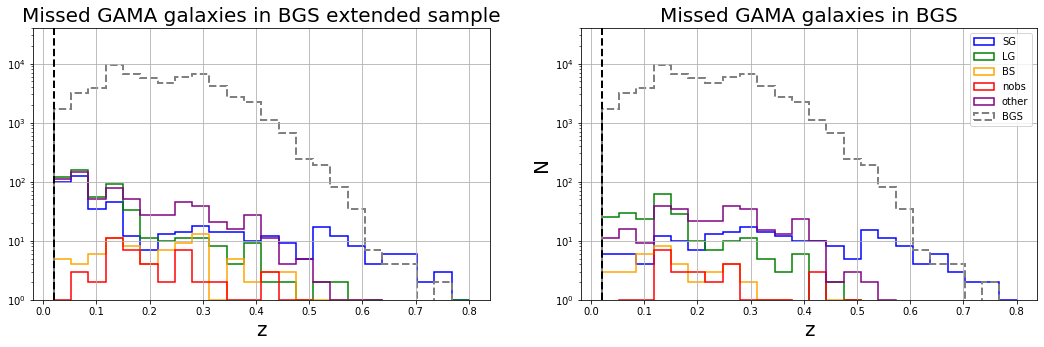

In [46]:
#
fig = plt.figure(figsize=(18, 5))

bins1 = np.linspace(0, 0.02, 1)
bins2 = np.linspace(0.02, 0.8, 25)
log=True

for i in [1, 2]:
    plt.subplot(1,2,i)
    mask = dr8ingama['RMAG'] < 20
    for key, col in zip(['SG', 'LG', 'BS',  'nobs', 'other'], ['blue', 'green', 'orange', 'red', 'purple']):
    
        if i == 1: keep = (rejs_gama[key])
        else: keep = (rejs_gama[key]) & (mask)
        #plt.hist(dr8_z[(keep) & (dr8_z < 0.02)], bins=1, log=log, histtype='step', color=col, lw=1.5, label=key)
        plt.hist(dr8_z[(keep) & (dr8_z > 0.002)], bins=bins2, log=log, histtype='step', color=col, lw=1.5, label=key)
        
    #plt.hist(dr8_z[(bgs) & (dr8_gama) & (dr8_z < 0.02)], bins=1, log=log, histtype='step', lw=2, ls='--', color='gray', label='BGS')
    plt.hist(dr8_z[(bgs) & (dr8_gama) & (dr8_z > 0.002)], bins=bins2, log=log, histtype='step', lw=2, ls='--', color='gray', label='BGS')
    
    plt.axvline(0.02, lw=2, c='k', ls='--')
    title = 'Missed GAMA galaxies in BGS'
    if i == 1: title = title + ' ' + 'extended sample'
    plt.title(title, size=20)
    plt.xlabel(r'z', size=20)
    #plt.ylim(0, 2350)
    plt.ylim(1, 40000)
    plt.grid()

plt.ylabel(r'N', size=20)
plt.legend()
file = pathdir+'rejs_gama_redshift'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0.3)
    

In [44]:
#
import pandas as pd

def heatmap2(rejs_gama=rejs_gama, mask=None, masklab=None, dr8_z=dr8_z, Area=Area, gaia_star=gaia_star, gaia_gal=gaia_gal, PSF=PSF):

    keys = list(rejs_gama.keys())

    matrix = [[0 for x in range(7)] for y in range(10)]
    if mask is None:
        mask = np.ones_like(dr8_z, dtype=bool)
    
    for i in range(len(keys)):
        
        val = rejs_gama[keys[i]]
    
        matrix[i][0] = np.sum((val) & (mask))/Area
        #matrix[i][1] = np.sum((val) & (cat['RMAG'] < 20))/Area
        matrix[i][1] = np.sum((val) & (dr8_z<0.002) & (mask))/Area
        matrix[i][2] = np.sum((val) & (dr8_z>0.002) & (mask))/Area 
        matrix[i][3] = np.sum((val) & (dr8_z>0.002) & (gaia_star) & (mask))/Area 
        matrix[i][4] = np.sum((val) & (dr8_z>0.002) & (gaia_gal) & (mask))/Area
        matrix[i][5] = np.sum((val) & (dr8_z>0.002) & (PSF) & (mask))/Area 
        matrix[i][6] = np.sum((val) & (dr8_z>0.002) & (~PSF) & (mask))/Area
    
    columns = ['main', 'GAMA Star', 'GAMA Gal', 'GAL & AEN star', 'GAL & AEN gal', 'GAL & PSF', 'GAL & noPSF' ]
    df = pd.DataFrame(np.array(matrix), columns=columns, index=keys)

    fig = plt.figure(figsize=(12,10))
    #log_norm = LogNorm(vmin=df.min().min(), vmax=df.max().max())
    ax = sns.heatmap(df, annot=True, annot_kws={"size": 14}, fmt=".2f", linewidths=.5, cmap='Reds')
    ax.figure.axes[-1].yaxis.label.set_size(20)
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    if masklab is None:
        file = pathdir+'rejs_gama_table'
    else:
        file = pathdir+'rejs_gama_table'+masklab
    
    fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    

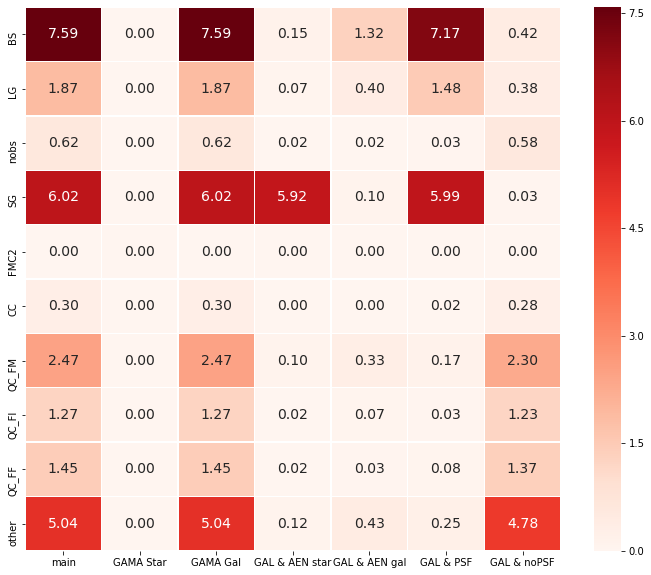

In [45]:
heatmap2(mask=dr8ingama['RMAG'] < 20, masklab='r20')

## Heatmap ignoring BS and NOBS

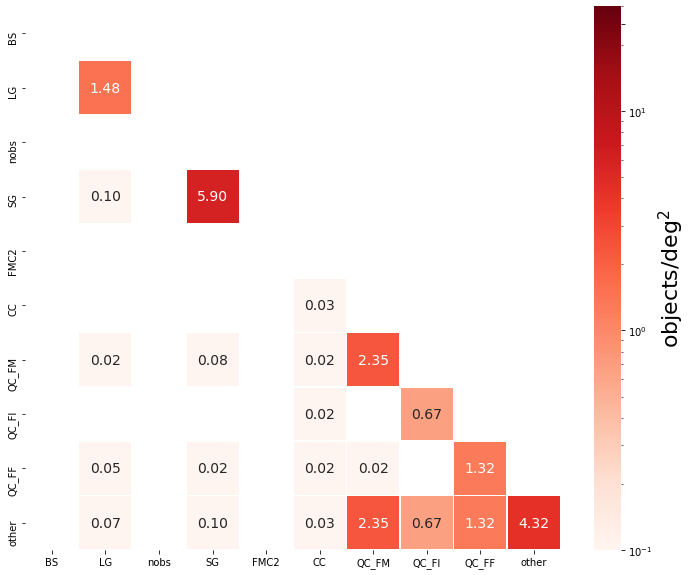

In [48]:
mask = ((dr8_z > 0.002)) & (dr8ingama['RMAG'] < 20) & (BS) & (nobs)
heatmap(rejs_gama, vmin=0.1, vmax=30, file=pathdir+'bgs_rejs_gama_heatmap_2.0', ticks=[0.1, 1, 10, 25], fmt=".2f", mask=mask)

## analysis of QCs

In [49]:
np.sum((rejs_gama['QC_FM']) & (dr8ingama['RMAG'] < 20))/Area

2.4674891630543514

In [50]:
def qcs_plots(df=None, mask=None, par=None, title=None, vline=None, limits=None):
    from QA import hexbin
    
    fig = plt.figure(figsize=(18, 6))
    
    x, y = limits[0], limits[1]
    plt.subplot(1, 3, 1)
    bins = np.linspace(x, y, 30)
    plt.hist(df[par+'_G'][(mask) & (df['RMAG'] < 20)], bins=bins, color='g', log=True, histtype='step', lw=2, label='G')
    plt.hist(df[par+'_R'][(mask) & (df['RMAG'] < 20)], bins=bins, color='r', log=True, histtype='step', lw=2, label='R')
    plt.hist(df[par+'_Z'][(mask) & (df['RMAG'] < 20)], bins=bins, color='b', log=True, histtype='step', lw=2, label='Z')
    plt.axvline(vline, ls='--', color='r')
    if title is not None: plt.title(title, size=14)
    plt.xlabel(par, size=14)
    plt.ylim(1,None)
    plt.legend()
    
    plt.subplot(1, 3, 2)
    bins = np.linspace(15, 21, 30)
    plt.hist(df['RMAG'][(mask)], bins=bins, color='k', alpha=0.7)
    if title is not None: plt.title(title, size=14)
    plt.xlabel('RMAG', size=14)
    
    plt.subplot(1, 3, 3)
    bins = np.linspace(0, 1.2, 30)
    plt.hist(dr8_z[(mask) & (df['RMAG'] < 20)], bins=bins, color='g', alpha=0.7)
    if title is not None: plt.title(title, size=14)
    plt.xlabel('z', size=14)
    
    #
    mask1 = (mask) & (dr8ingama['RMAG'] < 20)

    fig   = plt.figure(figsize=(18,6))
    gs     = gridspec.GridSpec(1, 3, hspace=0.15, wspace=0.10)

    for num, i in enumerate(['G', 'R', 'Z']):
        hexbin(coord={par+'_'+i:dr8ingama[par+'_'+i], 'z':dr8_z}, catmask=mask1, n=num, bins='log', title=None, cmap='viridis', 
               ylab=True, vline=vline, hline=None, fig=fig, gs=gs, xlim=(x,y), ylim=(0,1.0), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Area, cbar='horizontal')
        
    #
    mask2 = (mask)

    fig   = plt.figure(figsize=(18,6))
    gs     = gridspec.GridSpec(1, 3, hspace=0.15, wspace=0.10)

    for num, i in enumerate(['G', 'R', 'Z']):
        hexbin(coord={par+'_'+i:dr8ingama[par+'_'+i], 'RMAG':df['RMAG']}, catmask=mask2, n=num, bins='log', title=None, cmap='viridis', 
               ylab=True, vline=vline, hline=None, fig=fig, gs=gs, xlim=(x,y), ylim=(16,21), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Area, cbar='horizontal')
        
        

Below set of plots shows missed GAMA galaxies in BGS due `QC_FM`. This also do not include rejections by `BS` and `nobs`. Only the plots with redshift (`z`) in one of their axis show the distribution limited by rmag < 20, plots that involved `RMAG` are not limited. by looking at heatmap after removing rejections by `BS` and `nobs`, we see that `FM` does not share many galaxies with the other BGS cuts, then, the bimodal distribution we see is entirely dependant of FRACMASKED, this is, the set of galaxies rejected in the region 0 < `FRACMASKED_R` < 0.4 that should pass the BGS cuts, are being rejected by either `FRACMASKED_R`, `FRACMASKED_Z` or both.

Same applies for `FRACFLUX` and `FRACIN`. 

From postages, we can see that most of the time the galaxy is beeing rejected because it fails one of the three filters but passes the other two. Usualy the two values it passes are far from the veto limit or threshold limit and the one it fails the value is usually far from the other two. That means, for instance in `FRACMASKED` the condition is: FM_R < 0.4 & FM_G < 0.4 & FM_Z < 0.4, and we have a very nice galaxy with values: FM_R=0.001, FM_G=0.002, FM_Z=0.6. Then, the z-filter is the responsible of veting this galaxy.

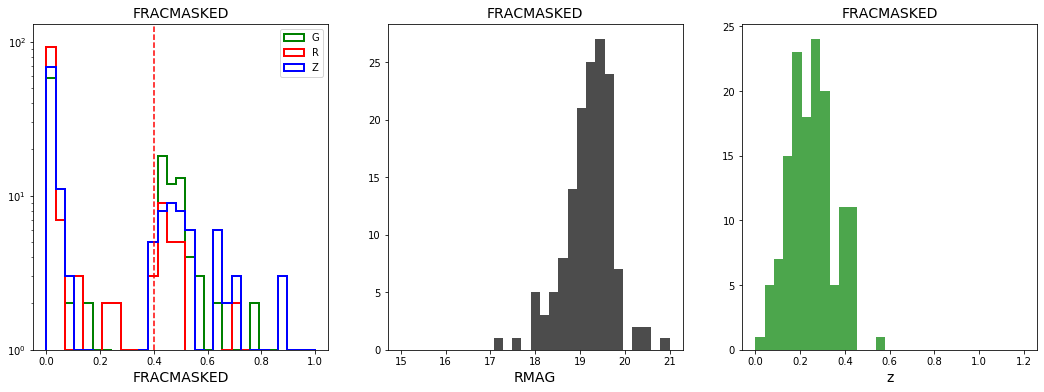

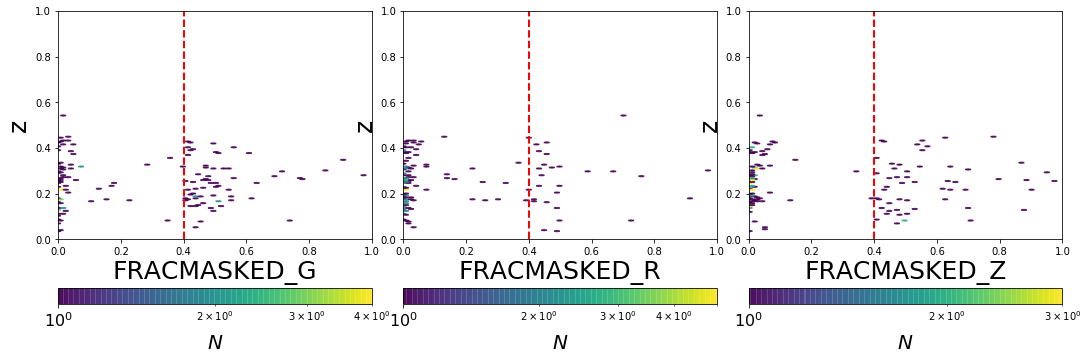

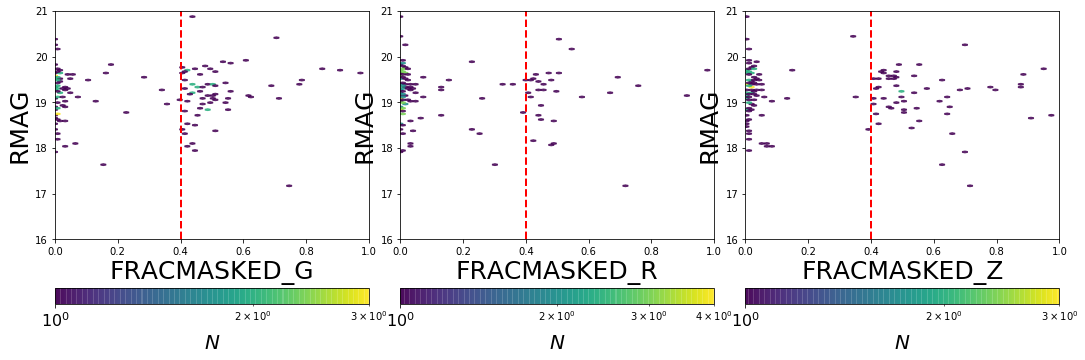

In [51]:
qcs_plots(df=dr8ingama, mask=(rejs_gama['QC_FM']) & (BS) & (nobs), par='FRACMASKED', title='FRACMASKED', vline=0.4, limits=[0, 1])

In [52]:
for idx in np.where(rejs_gama['QC_FM'])[0][:20]:
    print('R:%.3f \t G:%.3f \t Z:%.3f' 
          %(dr8ingama['FRACMASKED_R'][idx], dr8ingama['FRACMASKED_G'][idx], dr8ingama['FRACMASKED_Z'][idx]))

R:0.401 	 G:0.018 	 Z:0.014
R:0.006 	 G:0.024 	 Z:0.435
R:0.016 	 G:0.009 	 Z:0.541
R:0.005 	 G:0.004 	 Z:0.503
R:0.068 	 G:0.067 	 Z:0.648
R:0.010 	 G:0.006 	 Z:0.499
R:0.253 	 G:0.005 	 Z:0.656
R:0.005 	 G:0.465 	 Z:0.006
R:0.753 	 G:0.687 	 Z:0.006
R:0.005 	 G:0.006 	 Z:0.476
R:0.003 	 G:0.003 	 Z:0.950
R:0.009 	 G:0.008 	 Z:0.635
R:0.010 	 G:0.973 	 Z:0.005
R:0.008 	 G:0.463 	 Z:0.021
R:0.455 	 G:0.004 	 Z:0.015
R:0.006 	 G:0.002 	 Z:0.409
R:0.669 	 G:0.010 	 Z:0.013
R:0.044 	 G:0.046 	 Z:0.542
R:0.387 	 G:0.224 	 Z:0.501
R:0.260 	 G:0.553 	 Z:0.136


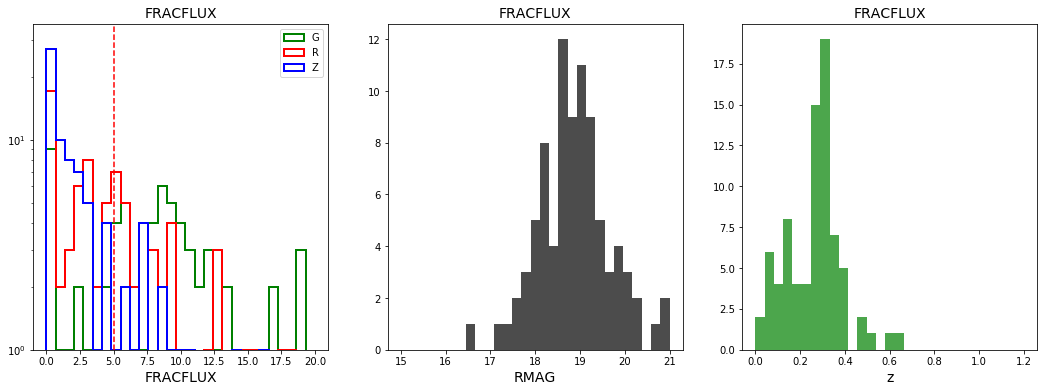

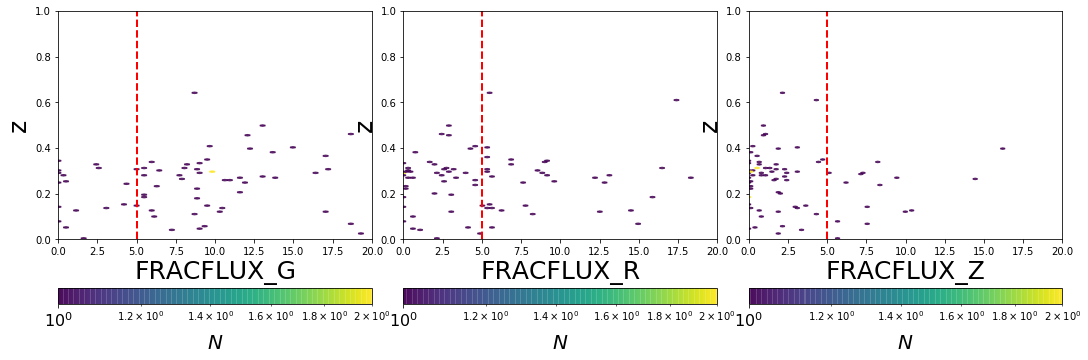

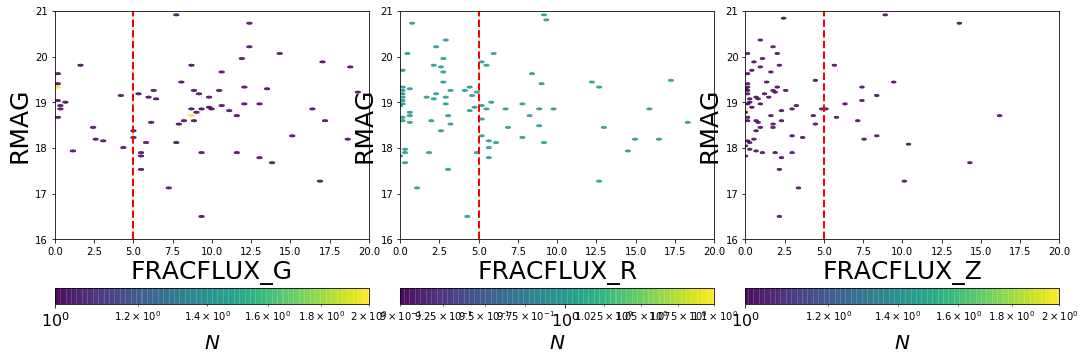

In [53]:
qcs_plots(df=dr8ingama, mask=(rejs_gama['QC_FF']) & (BS) & (nobs), par='FRACFLUX', title='FRACFLUX', vline=5, limits=[0, 20])

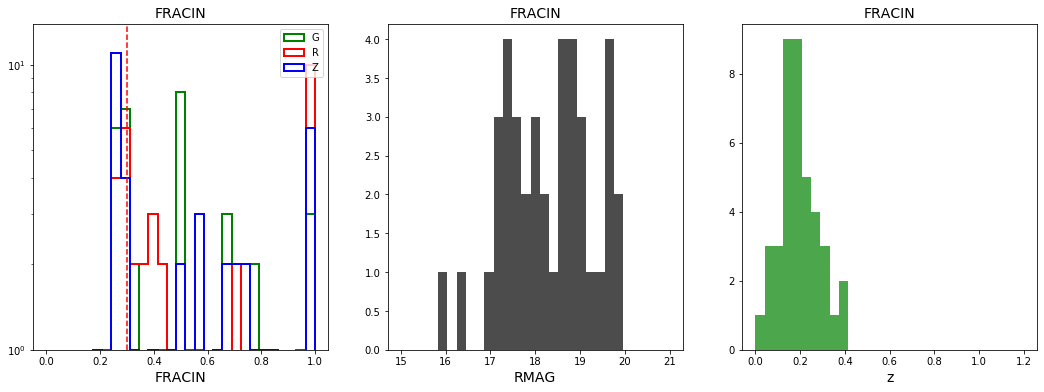

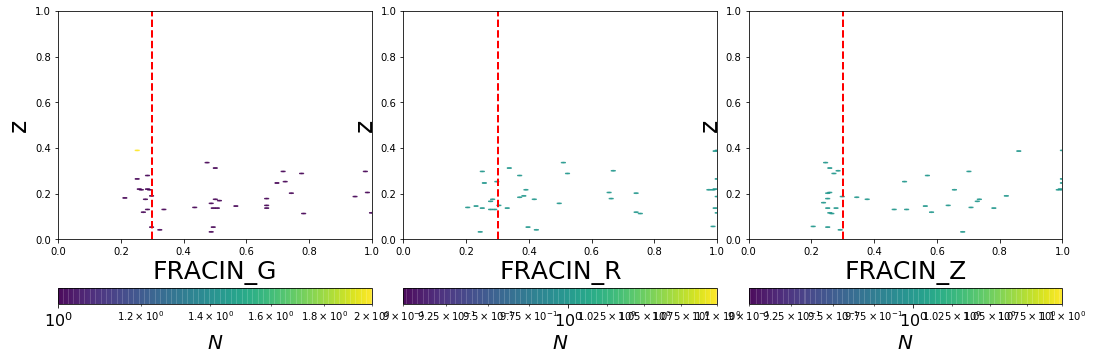

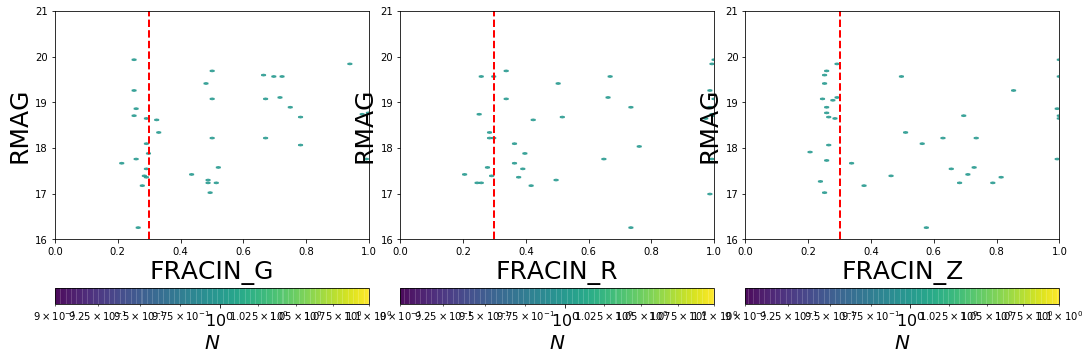

In [54]:
qcs_plots(df=dr8ingama, mask=(rejs_gama['QC_FI']) & (BS) & (nobs), par='FRACIN', title='FRACIN', vline=0.3, limits=[0, 1])

### Postages FM

Progress...100%|####################################################|


Colour key:
	 BGS --> lime
	 QCs_rej --> royalblue
	 other --> red


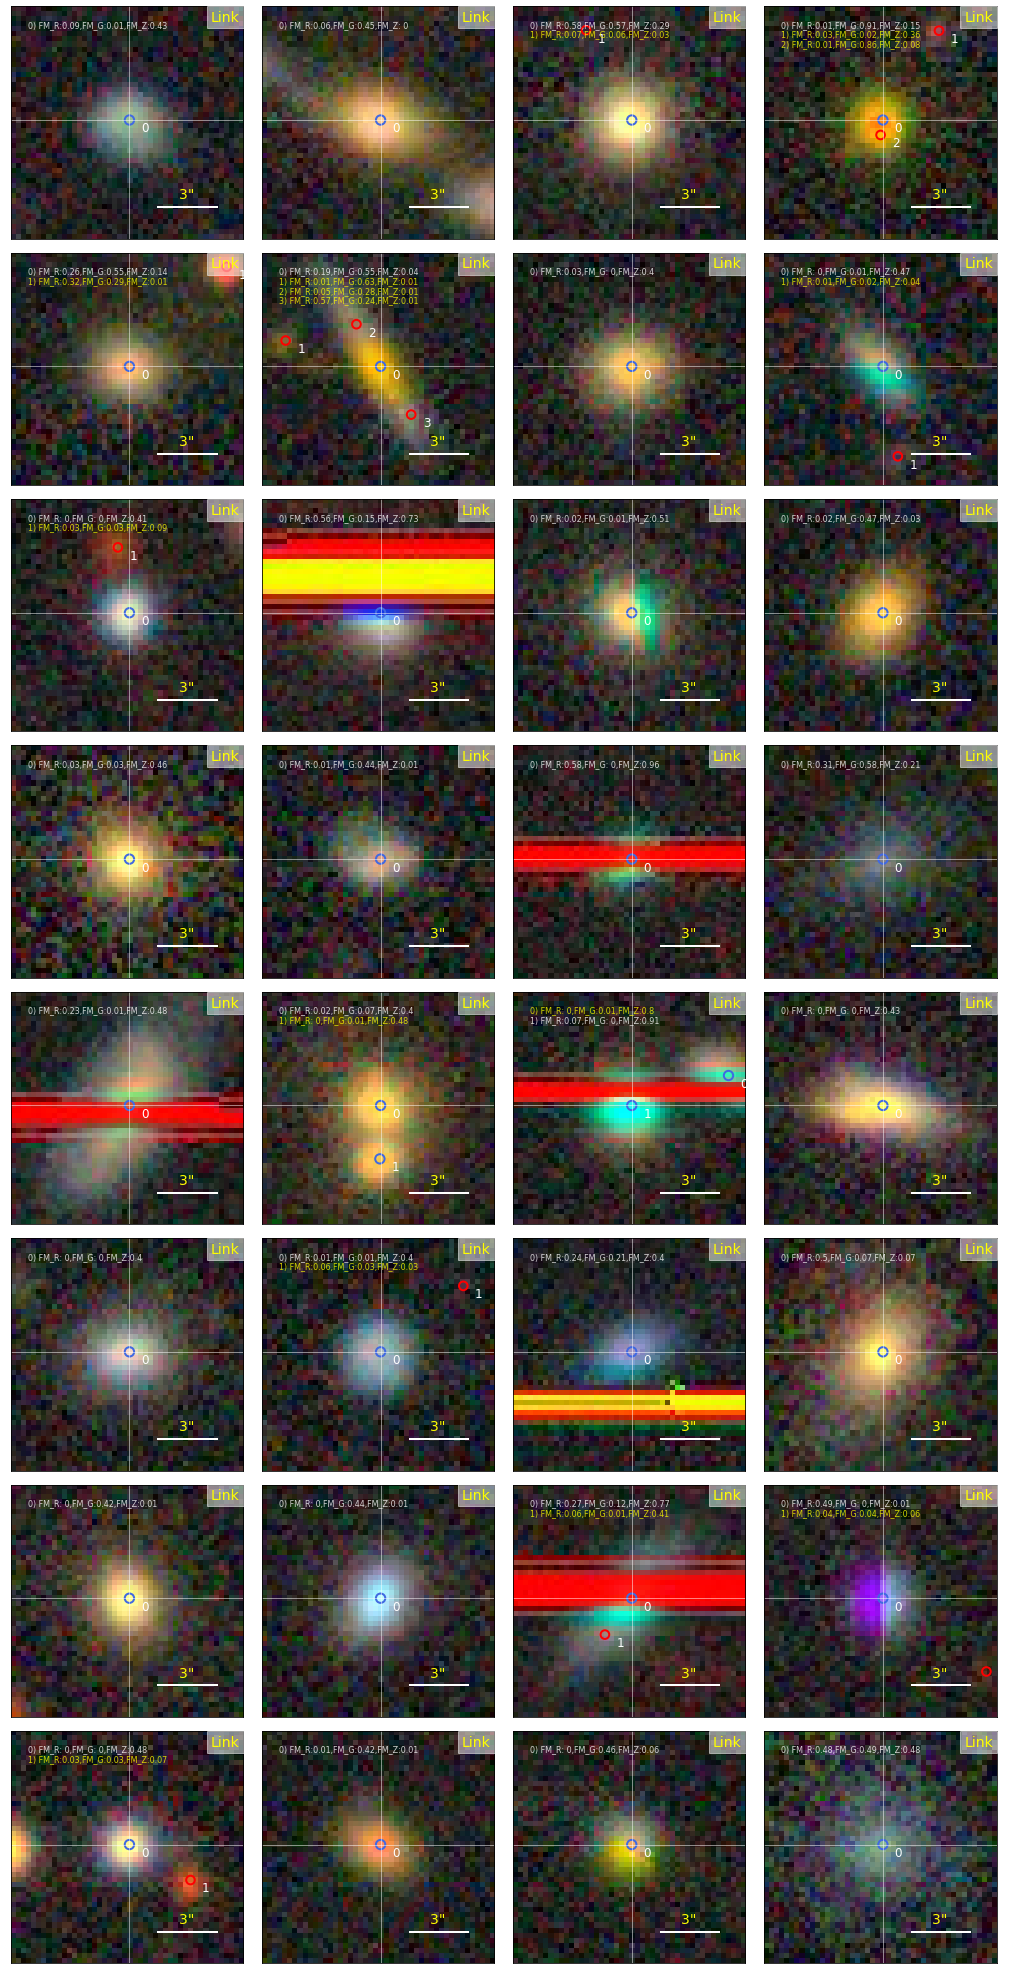

In [55]:
#Get the postages...
veto = {'BGS':bgs, 'QCs_rej':(rejs_gama['QC_FM']) & (BS) & (nobs) & (dr8ingama['RMAG'] < 20)}
info = {'FM_R':np.round(dr8ingama['FRACMASKED_R'], 2),'FM_G':np.round(dr8ingama['FRACMASKED_G'], 2), 'FM_Z':np.round(dr8ingama['FRACMASKED_Z'], 2)}
layer = 'dr8'

idx = np.where((rejs_gama['QC_FM']) & (BS) & (nobs) & (dr8ingama['RMAG'] < 20))[0]
#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[dr8ingama['RA'], dr8ingama['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer, radius=3/3600., m=2, grid=[8,4], 
                    savefile='%s/rejs_gama_FM' %(pathdir), layer2=None, layer2Mode=None, 
                        isLG=False, title=None, markers=False, colorkey=True)

### Postages FF

Progress...100%|####################################################|


Colour key:
	 BGS --> lime
	 QCs_rej --> royalblue
	 other --> red


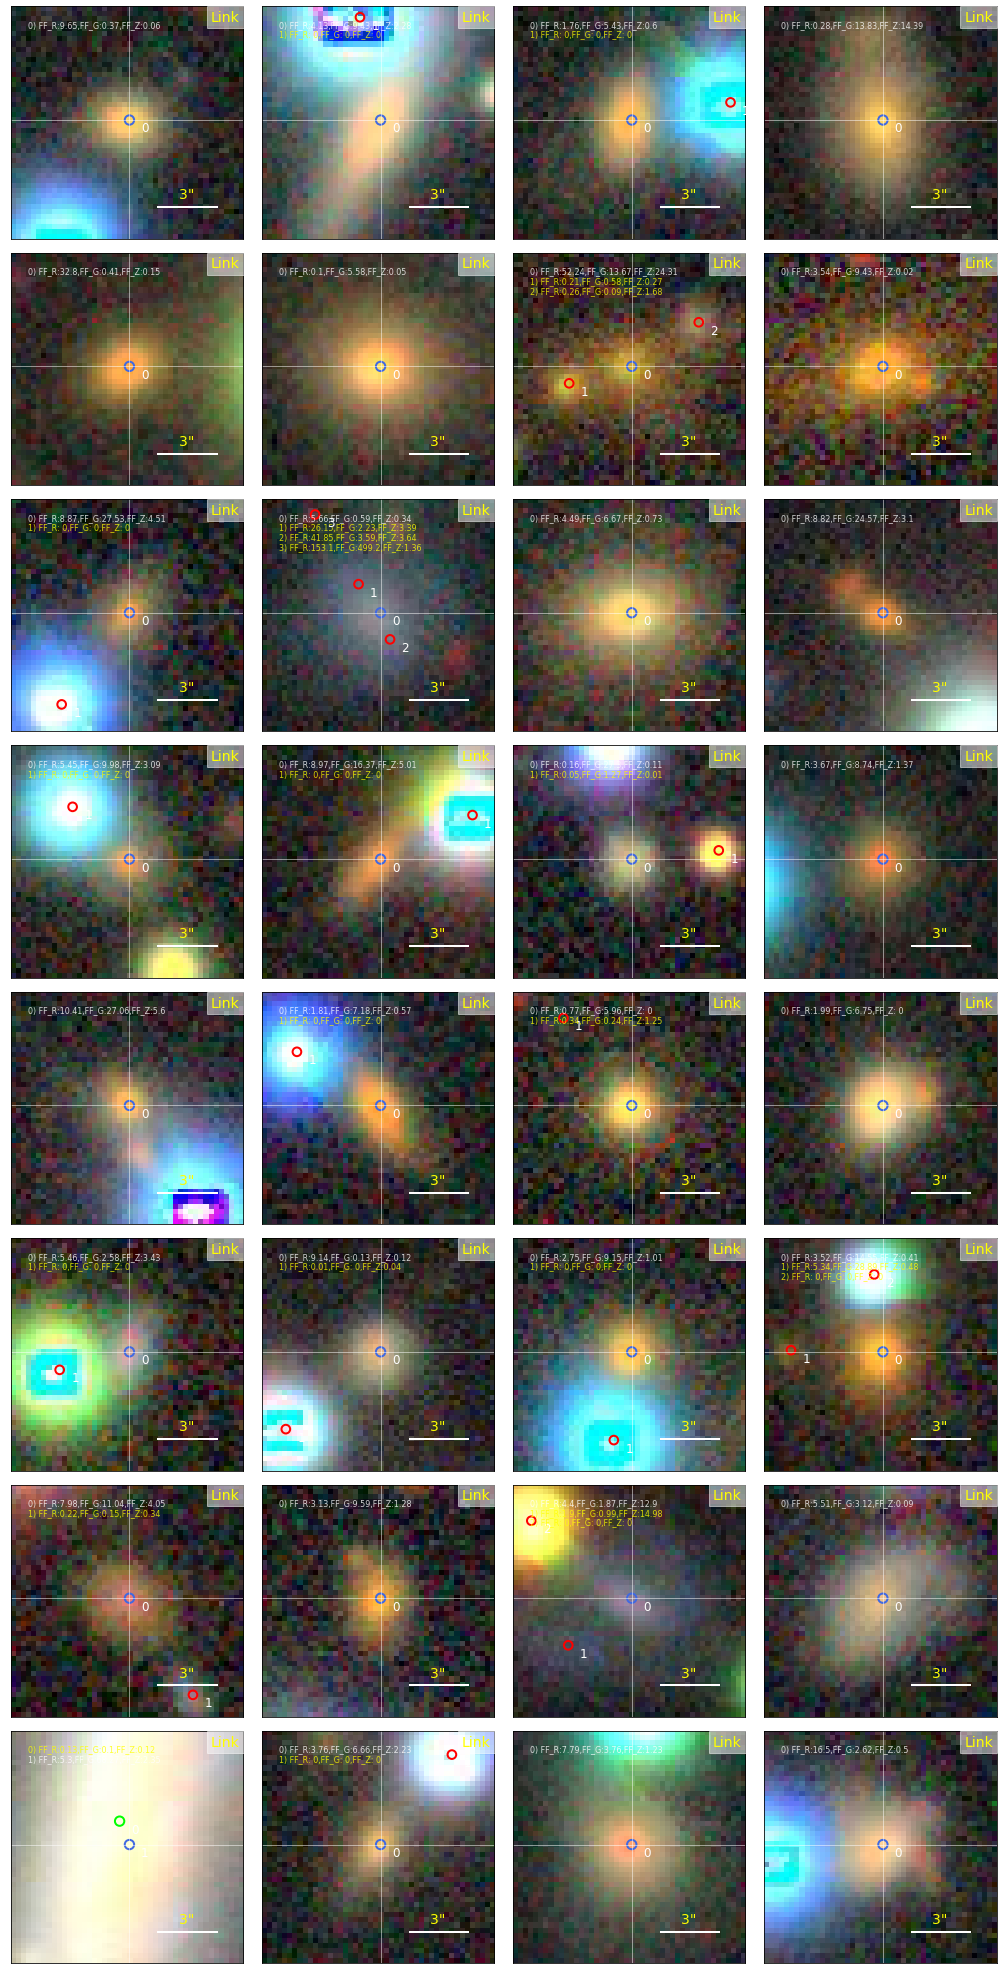

In [56]:
#Get the postages...
veto = {'BGS':bgs, 'QCs_rej':(rejs_gama['QC_FF']) & (BS) & (nobs) & (dr8ingama['RMAG'] < 20)}
info = {'FF_R':np.round(dr8ingama['FRACFLUX_R'], 2),'FF_G':np.round(dr8ingama['FRACFLUX_G'], 2), 'FF_Z':np.round(dr8ingama['FRACFLUX_Z'], 2)}
layer = 'dr8'

idx = np.where((rejs_gama['QC_FF']) & (BS) & (nobs) & (dr8ingama['RMAG'] < 20))[0]
#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[dr8ingama['RA'], dr8ingama['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer, radius=3/3600., m=2, grid=[8,4], 
                    savefile='%s/rejs_gama_FF' %(pathdir), layer2=None, layer2Mode=None, 
                        isLG=False, title=None, markers=False, colorkey=True)

### Postages FI

Progress...100%|####################################################|


Colour key:
	 BGS --> lime
	 QCs_rej --> royalblue
	 other --> red


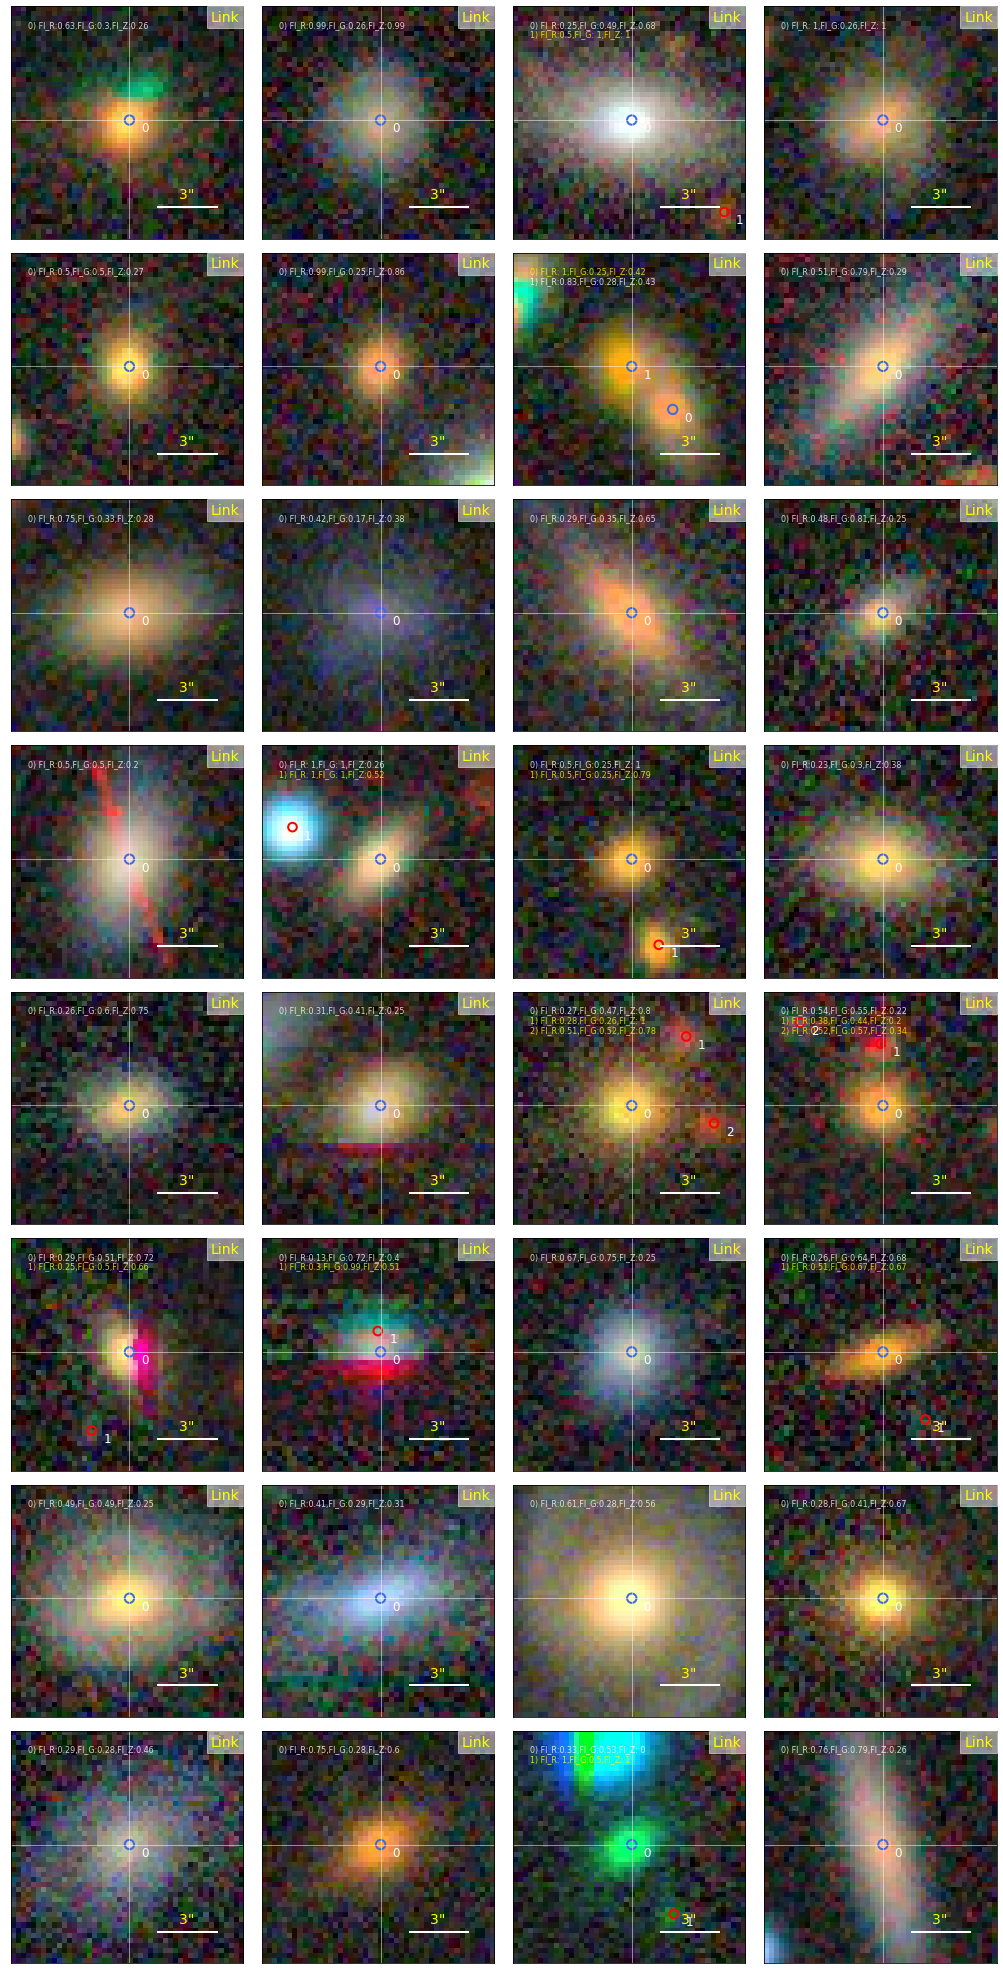

In [58]:
#Get the postages...
veto = {'BGS':bgs, 'QCs_rej':(rejs_gama['QC_FI']) & (BS) & (nobs) & (dr8ingama['RMAG'] < 20)}
info = {'FI_R':np.round(dr8ingama['FRACIN_R'], 2),'FI_G':np.round(dr8ingama['FRACIN_G'], 2), 'FI_Z':np.round(dr8ingama['FRACIN_Z'], 2)}
layer = 'dr8'

idx = np.where((rejs_gama['QC_FI']) & (BS) & (nobs) & (dr8ingama['RMAG'] < 20))[0]
#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[dr8ingama['RA'], dr8ingama['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer, radius=3/3600., m=2, grid=[8,4], 
                    savefile='%s/rejs_gama_FI' %(pathdir), layer2=None, layer2Mode=None, 
                        isLG=False, title=None, markers=False, colorkey=True)

# AEN comparisson with Grr

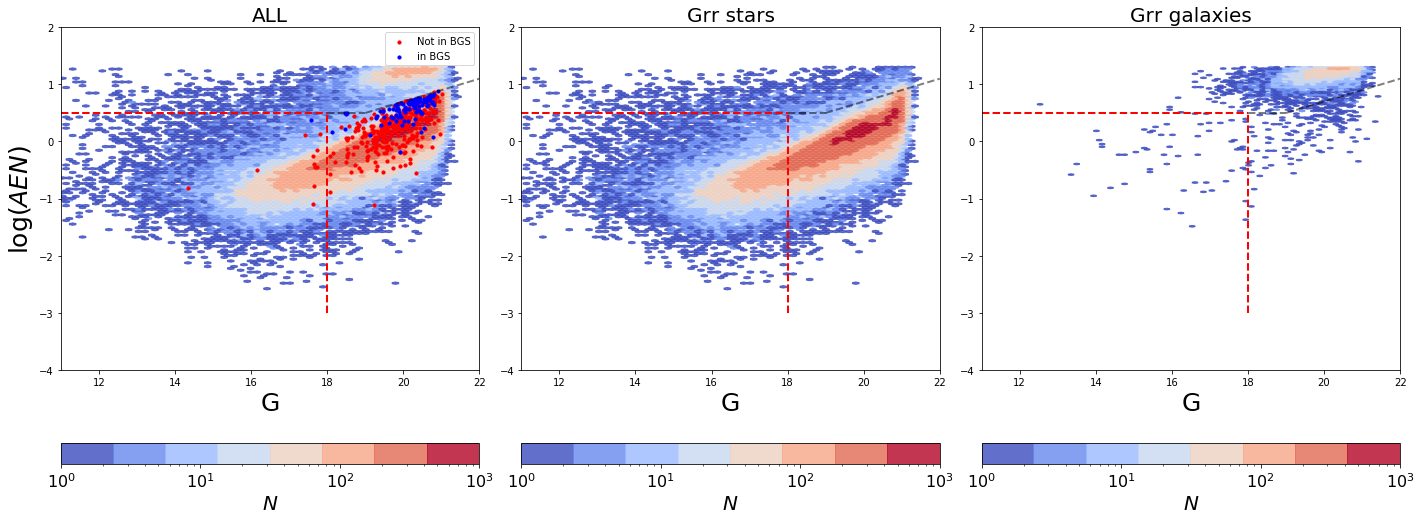

In [55]:
from QA import hexbin

coord = {'G':dr8ingama['G'], r'$\log(AEN)$':np.log10(dr8ingama['AEN'])}
masks = [(inGAIA) ,(rejs['SG']) & (inGAIA), (~rejs['SG']) & (inGAIA)]
titles = ['ALL', 'Grr stars', 'Grr galaxies']
vmin, vmax = 1, 1000
    
fig    = plt.figure(figsize=(8*len(masks),9))
gs     = gridspec.GridSpec(1,len(masks),hspace=0.10,wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
    
for i, mask in enumerate(masks):
        
    if (i%len(masks)==0): ylab=True
    else: ylab = False
        
    hexbin(coord=coord, catmask=mask, n=i, bins='log', title=titles[i], cmap=cmap, 
               ylab=ylab, vline=None, hline=None, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=False, 
                   file=None, area=None, xlim=[11, 22], ylim=[-4, 2], cbar='horizontal')
    
    if i == 0:
        x, y = coord.keys()
        mask1 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (bgs)
        mask2 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (~bgs)
        plt.scatter(coord[x][mask2], coord[y][mask2], s=10, c='red', label=r'Not in BGS')
        plt.scatter(coord[x][mask1], coord[y][mask1], s=10, c='blue', label=r'in BGS')
        plt.legend()
    
    x_N1 = np.linspace(11, 18, 4)
    x_N2 = np.linspace(19, 22, 4)
    plt.plot(x_N1, x_N1*0+0.5, color='r', ls='--', lw=2)
    plt.plot(np.full(4, 18), np.linspace(-3, 0.5, 4), color='r', ls='--', lw=2)
    plt.plot(x_N2, 0.5 + 0.2*(x_N2 - 19.), color='k', ls='--', lw=2, alpha=0.5)
    plt.plot(np.linspace(18,19,3), np.full(3, 0.5), color='k', ls='--', lw=2, alpha=0.5)

file = pathdir+'G_logAEN'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

AEN stars matched with GAMA Galaxies and:
* in BGS
* Not in BGS


In [56]:
mask1 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (bgs)
mask2 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (~bgs)
print('dens. of GAMA galaxies & AEN stars in LS & GAMA & ~BGS: %.3f' %(np.sum(mask2)/Area))
print('dens. of GAMA galaxies & AEN stars in LS & GAMA & BGS: %.3f' %(np.sum(mask1)/Area))

mask3 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (dr8ingama['G'] < 19)
print('dens. of GAMA galaxies & AEN stars with G < 19 in LS & GAMA: %.3f' %(np.sum(mask3)/Area))

mask4 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (dr8ingama['G'] < 18)
print('dens. of GAMA galaxies & AEN stars with G < 18 in LS & GAMA: %.3f' %(np.sum(mask4)/Area))

dens. of GAMA galaxies & AEN stars in LS & GAMA & ~BGS: 7.269
dens. of GAMA galaxies & AEN stars in LS & GAMA & BGS: 1.634
dens. of GAMA galaxies & AEN stars with G < 19 in LS & GAMA: 1.134
dens. of GAMA galaxies & AEN stars with G < 18 in LS & GAMA: 0.200


## example of objects not in LS & in GAMA

in GAMA but not in LS: N=242, density=4.03


Text(0.5, 0, 'z')

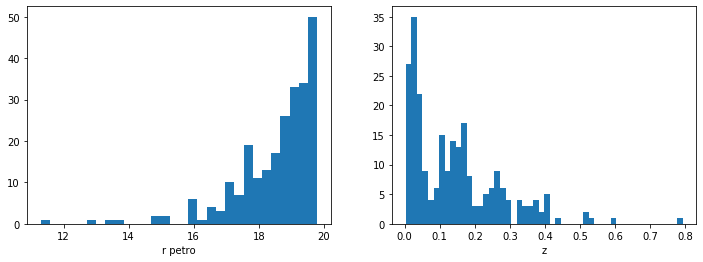

In [57]:
keep = (~tab[dr]) & (tab['gama'])
print('in GAMA but not in LS: N=%i, density=%.2f' %(np.sum(keep), np.sum(keep)/Area))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(tab['rpetro'][keep], bins=30)
plt.xlabel(r'r petro')

plt.subplot(1,2,2)
plt.hist(tab['Z'][keep], bins=50)
plt.xlabel(r'z')


Progress...N/A%|                                                    |

sample size: 238


Progress...100%|####################################################|


Colour key:
	 bgs & gama --> lime
	 bgs & ~gama --> royalblue
	 ~bgs & gama & LS --> purple
	 ~bgs & gama & ~LS --> orange
	 other --> red


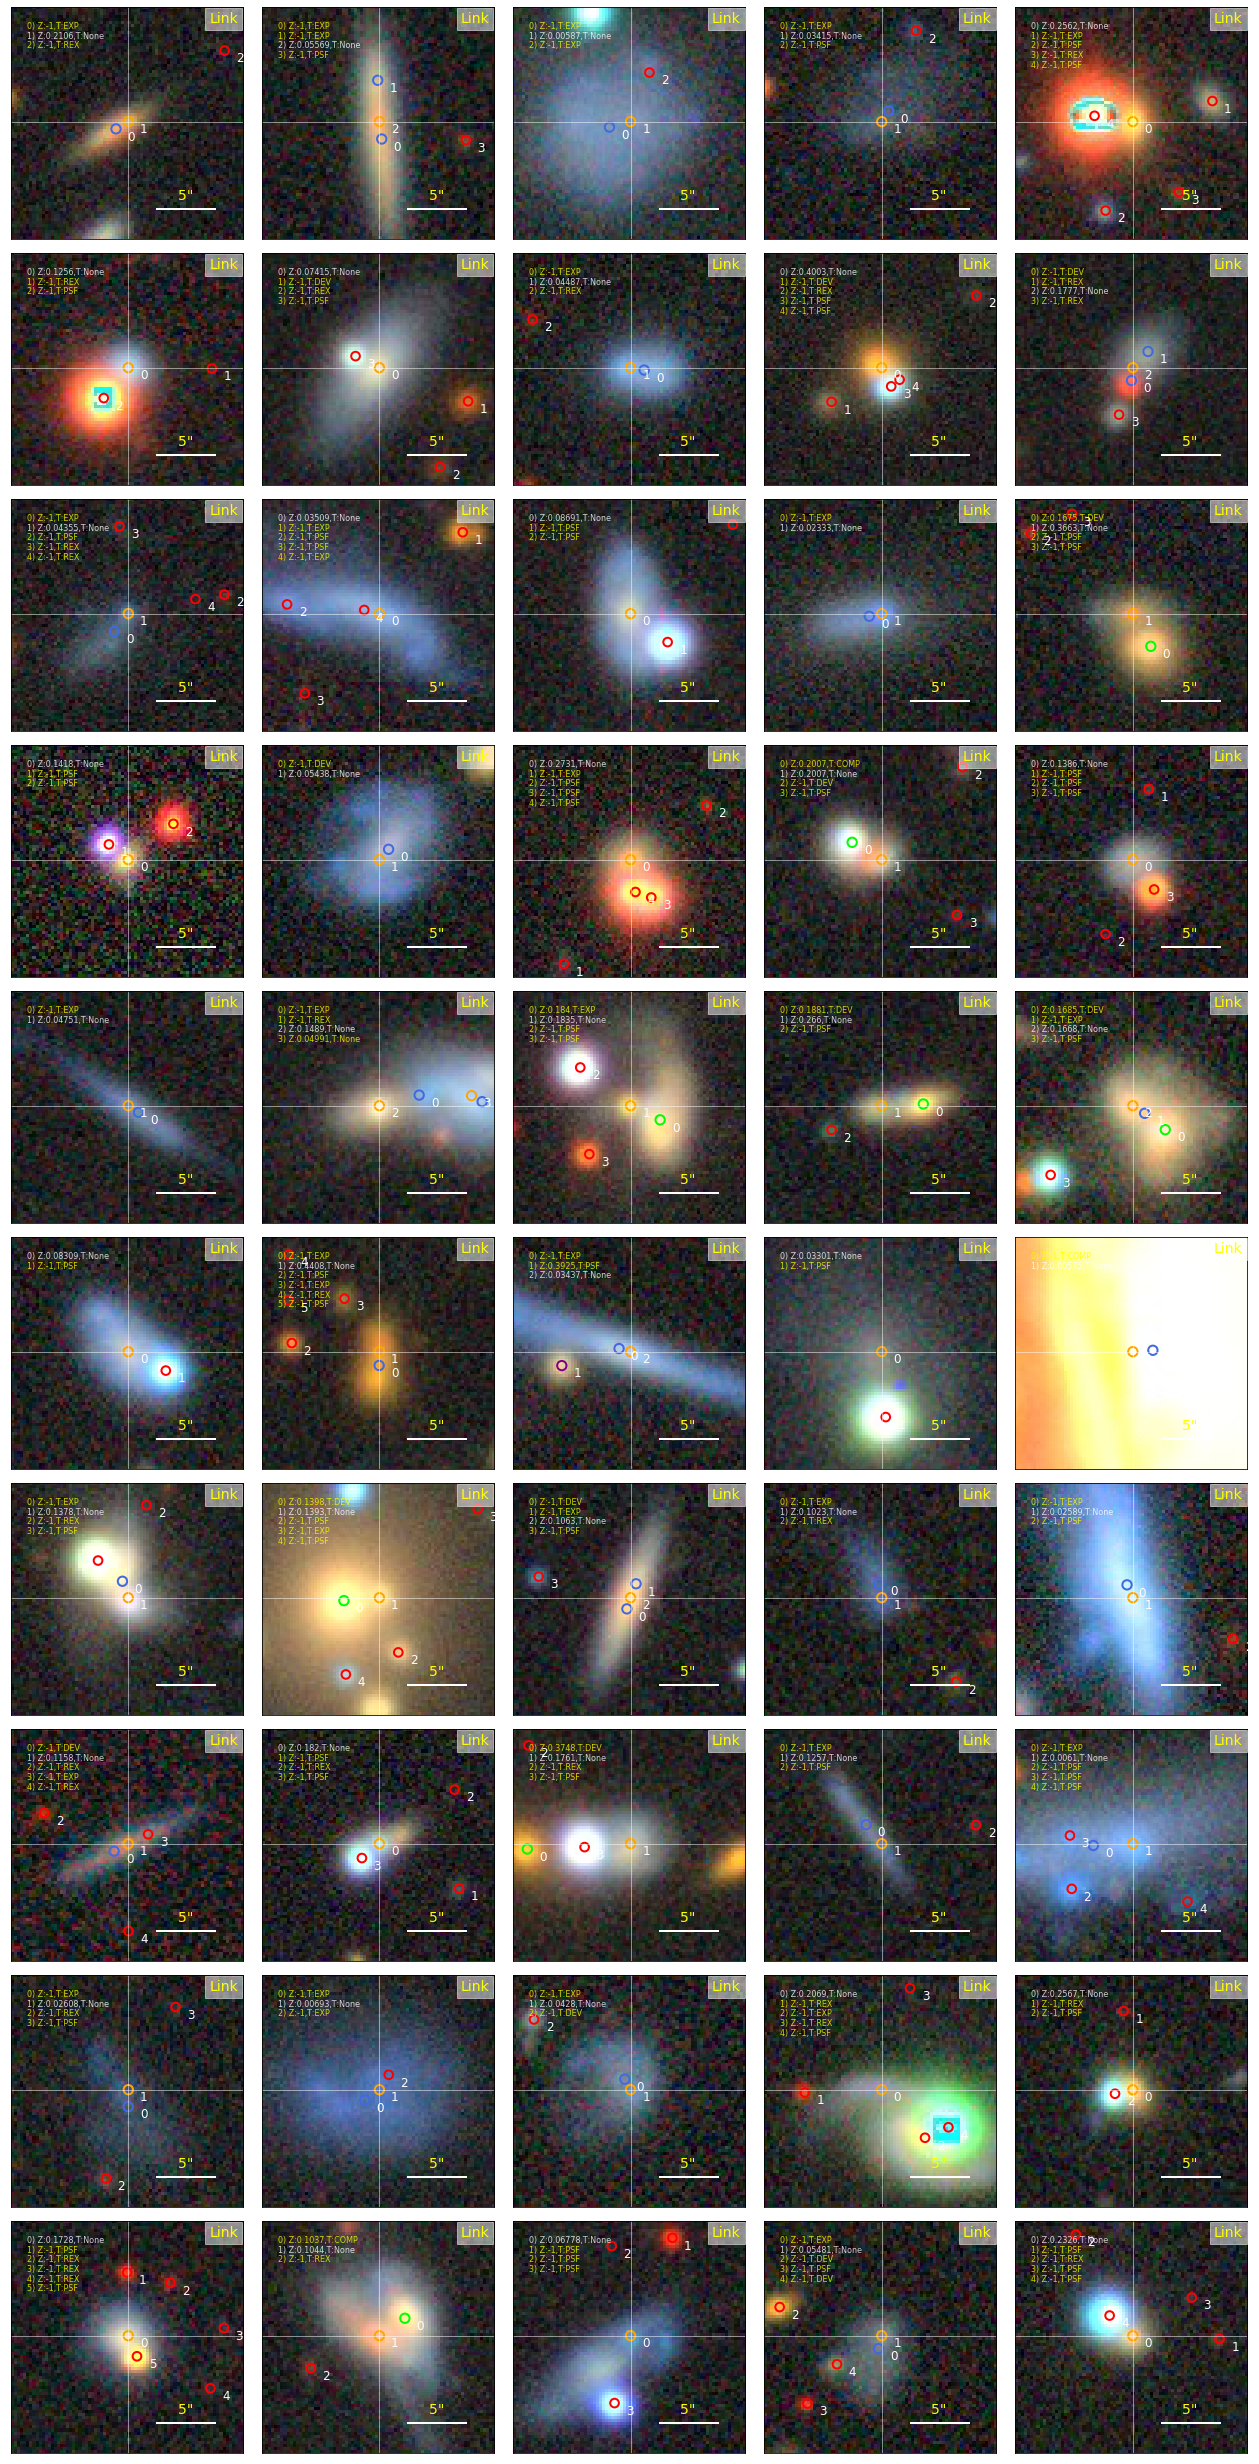

In [58]:
from postages_images import postages_circle

veto = {'bgs & gama':(tab['bgs']) & (tab['gama']),
        'bgs & ~gama':(tab['bgs']) & (~tab['gama']),
        '~bgs & gama & LS':(~tab['bgs']) & (tab['gama']) & (tab['dr8']),
        '~bgs & gama & ~LS':(~tab['dr8']) & (tab['gama'])  
       }
#veto = {'inLG':tab['lg'], 'outLG':~tab['lg']}
#info = {'Z':tab['Z'], 'isLG':tab['lgbit'].astype(str)}
info = {'Z':tab['Z'], 'T':tab['TYPE'].astype(str)}
layer_dr8='dr8'
#'dr8-model'
#'dr8-resid'

#get indexes of LSLGA
rpetromin, rpetromax = 14, 20
idx = list(np.where((~tab['dr8']) & (tab['gama']) & (tab['rpetro'] < rpetromax)  & (tab['rpetro'] > rpetromin)))[0]
print('sample size: %i' %(len(idx)))

#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[tab['RA'], tab['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr8, radius=5/3600., m=2, grid=[10,5], 
                    savefile='%sin_GAMA_not_LS8_rpetro_%.1f_%.1f' %(pathdir, rpetromin, rpetromax), layer2=None, layer2Mode='merge', 
                        isLG=False, title=None, markers=False, colorkey=True)
